# ViTSD Model

In this notebook we will create our model (Vision Transformers for Small Dataset) and train it.

# Installing the libraries

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 8.2 MB/s eta 0:00:00


# Importing libraries

In [ ]:
import os
import cv2
import math
import torch
import numpy as np
from os import path
import pandas as pd
import torch.nn as nn
from torch import Tensor
from typing import Tuple, List
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

For the Optimization:

In [ ]:
from skopt import forest_minimize, gbrt_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

# Defining the Model

## Defining the Flatten Layer:

In [ ]:
class Flatten(nn.Module):

    def __init__(self, num_neurons_flatten: int):
      
        """
        
        Constructor for the Flatten module.
        
        Module that flattens the input tensor into a 2D tensor.

        Args:
        - num_neurons_flatten (int): number of neurons to flatten the input tensor to

        Attributes:
        - num_neurons_flatten (int): number of neurons to flatten the input tensor to
        
        """
        super(Flatten, self).__init__()
        self.num_neurons_flatten = num_neurons_flatten

    def forward(self, x: Tensor) -> Tensor:
      
        """
        
        Forward pass of the Flatten module.
        Args:
        - x (Tensor): input tensor

        Returns:
        - out (Tensor): flattened tensor
        
        """
        out = x.contiguous().view(-1, self.num_neurons_flatten)
        return out

## Defining the FeedFoward Layer:

In [ ]:
class FeedForward(nn.Module):

  def __init__(self,
               in_features: int,
               out_features: int,
               activation_function: nn.Module,
               num_hidden_neurons: int,
               num_hidden_layers: int,
               task_type: str,
               dropout: float = 0.1,):
    """
      
    Initializes a FeedForward neural network.
    The FeedForward class is a neural network module in PyTorch that represents a multi-layer
    feedforward neural network. The class takes as input the number of input features, output
    features, activation function, number of hidden neurons, number of hidden layers, and
    dropout rate. It initializes a list of PyTorch modules that defines the layers of the neural
    network, with a linear layer, activation function, and dropout layer for the first layer,
    and a sequence of linear, activation, and dropout layers for the subsequent hidden layers.
    The final layer is a linear layer followed by an activation function choosen by the task_type
    argument (Identity function if task_type='regression', Sigmoid if task_type='binary_classification'
    or Softmax if task_type='multi_classification'). The forward method of the class takes an input
    tensor and applies each layer in the list of PyTorch modules in sequence to produce an output
    tensor, which represents the output of the feedforward neural network.

    Args:
      -in_features (int): number of input features.
      -out_features (int): number of output features.
      -activation_function (nn.Module): activation function to be used in hidden layers.
      -final_activation_function (nn.Module): activation function to be used in final layer (depends on the task).
      -num_hidden_neurons (int): number of neurons in each hidden layer.
      -num_hidden_layers (int): number of hidden layers in the network.
      -task_type (str): Task to be solved by the neural network. Must be one of: 'regression', 'binary_classification' or 'multi_classification'.
      -dropout (float, optional): dropout probability. Defaults to 0.1.
      
    Attributes:
      -feedforward (nn.ModuleList): List with each layer of the neural network.
      
    """
      
    super(FeedForward,self).__init__()
    self.feedforward = nn.ModuleList()

    # add input layer
    self.feedforward.append(nn.Linear(in_features,num_hidden_neurons))
    self.feedforward.append(activation_function())
    self.feedforward.append(nn.Dropout(dropout))

    # add hidden layers
    for _ in range(num_hidden_layers):
      self.feedforward.append(nn.Linear(num_hidden_neurons,num_hidden_neurons))
      self.feedforward.append(activation_function())
      self.feedforward.append(nn.Dropout(dropout))

    if task_type=='regression':

      self.final_activation_function = nn.Identity()

    elif task_type=='binary_classification':

      self.final_activation_function = nn.Sigmoid()

      if out_features != 1:
        raise ValueError("task_type='binary_classification' only supports 1 neuron on the end of the neural network (out_features = 1). If you want to use more than one neuron, use 'multi_classification' instead.")

    elif task_type=='multi_classification':

      self.final_activation_function = nn.Softmax(dim=1)

    else:
      raise ValueError("task_type must be either of 'regression','binary_classification' or 'multi_classification'.")

    # add output layer
    self.feedforward.append(nn.Linear(num_hidden_neurons,out_features))
    self.feedforward.append(self.final_activation_function)

  def forward(self,x: Tensor)->Tensor:
    
    """
    
    Computes the forward pass of the feedforward neural network.
    Args:
       x (Tensor): input tensor of shape [batch_size, in_features]
    Returns:
       Tensor: output tensor of shape [batch_size, out_features]
       
    """
    
    for layer in self.feedforward:
      x = layer(x)
    return x

## Defining the ShiftedPatchTokenization Layer

In [ ]:
class ShiftedPatchTokenization(nn.Module):

    """

    Shifted Patch Tokenization module for creating image patches 
    with positional encodings for use in transformers.

    """

    def __init__(self, image_size, patch_size, embed_dim, in_channels):

        """

        Initializes the ShiftedPatchTokenization module.
        
        Args:
            image_size (int or tuple): The size of the input image. If an integer is given, the image is assumed to have the same width and height.
            patch_size (int or tuple): The size of each patch. If an integer is given, the patch is assumed to have the same width and height.
            embed_dim (int): The dimension of the output embedding.
            in_channels (int): The number of channels in the input image.

        """

        super(ShiftedPatchTokenization, self).__init__()

        # If image_size or patch_size is an integer, convert it to a tuple with equal width and height
        if type(image_size) == int:
            image_size = (image_size, image_size)
        if type(patch_size) == int:
            patch_size = (patch_size, patch_size)

        self.embed_dim = embed_dim
        self.image_width, self.image_height = image_size
        self.patch_width, self.patch_height = patch_size

        # Check if the image dimensions are divisible by the patch dimensions
        if self.image_width % self.patch_width != 0 or self.image_height % self.patch_height != 0:
            raise ValueError("The image's width must be divisible by the patche's width and the image's height, by the patch's height")

        # Calculate the number of patches
        self.num_patches = int((self.image_width // self.patch_width) * (self.image_height // self.patch_height))

        # Set the translation amounts
        self.delta_x = self.patch_width // 2
        self.delta_y = self.patch_height // 2

        # Set the total number of channels for the output tensor
        self.num_transformations = 4
        self.total_channels = in_channels * (self.num_transformations + 1)

        # Define the projection layer
        self.projection = nn.Conv2d(in_channels=self.total_channels,
                                    out_channels=self.embed_dim,
                                    kernel_size=(self.patch_width, self.patch_height),
                                    stride=(self.patch_width, self.patch_height))

        # Define the layer normalization layer
        self.layer_norm = nn.LayerNorm(self.embed_dim)

        # Define the CLS token
        self.cls_token = nn.Parameter(torch.zeros((1, 1, self.embed_dim)))

        # Define the positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros((1, 1 + self.num_patches, self.embed_dim)))

    def translate_image(self, image: Tensor, delta_x: int, delta_y: int, device: torch.device):

        """

        Translates an image by a given amount.
        
        Args:
            image (torch.Tensor): The input image.
            delta_x (int): The amount to translate the image along the x-axis.
            delta_y (int): The amount to translate the image along the y-axis.
        
        Returns:
            The translated image.

        """

        translated_image = transforms.functional.affine(image, angle=0, translate=(delta_x, delta_y), fill=0, scale=1, shear=0)
        translated_image = translated_image.to(device)
        return translated_image

    def get_num_patches(self):

        """

        Returns the number of patches.
        
        Returns:
            The number of patches.

        """

        return self.num_patches

    def forward(self, image: Tensor, device: torch.device) -> Tensor:

        """

        Forward pass of the ShiftedPatchTokenization module.

        Args:
        - image (torch.Tensor): a tensor representing an image, of size (batch_size, in_channels, image_height, image_width)

        Returns:
        - patches (torch.Tensor): a tensor of tokenized image patches, of size (batch_size, num_patches+1, embed_dim)

        """

        batch_size = image.size(0)
        

        # generate shifted versions of the image
        shift_left_up = self.translate_image(image, -self.delta_x, -self.delta_y,device)
        shift_right_up = self.translate_image(image, self.delta_x, -self.delta_y,device)
        shift_left_down = self.translate_image(image, -self.delta_x, self.delta_y,device)
        shift_right_down = self.translate_image(image, self.delta_x, self.delta_y,device)

        # concatenate the original image with its shifted versions
        concatenated_images = torch.cat((image, shift_left_up, shift_right_up, shift_left_down, shift_right_down), dim=1)

        # project the concatenated image onto a lower-dimensional embedding
        projected_patches = self.projection(concatenated_images)
        patches = projected_patches.flatten(2)
        patches = patches.transpose(1, 2)

        patches.to(device)

        # apply layer normalization to the patches
        patches = self.layer_norm(patches)

        # append a learnable "class token" to the beginning of the patch sequence
        cls = self.cls_token.expand(batch_size, -1, -1)
        patches = torch.cat((cls, patches), dim=1)

        patches.to(device)

        # add learnable positional encodings to the patches
        patches = patches + self.positional_encoding

        return patches

## Defining the MultiLocallySelfAttention Layer

In [ ]:
class MultiLocallySelfAttention(nn.Module):

    def __init__(self, embed_dim: int, num_heads: int, num_patches: int, device: torch.device, dropout: float = 0.1):

        """

        Initializes a MultiLocallySelfAttention layer.

        Args:
            embed_dim (int): the embedding dimensionality
            num_heads (int): the number of attention heads
            num_patches (int): the number of image patches
            device (torch.device): the device to run the model on
            dropout (float): the dropout rate

        """
        
        super().__init__()

        # Store layer parameters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.dropout = dropout

        # Initialize attention mask (a lower triangular matrix with True values)
        self.attn_mask = torch.eye(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool, requires_grad=False)
        self.attn_mask = self.attn_mask.to(device)

        # Initialize multi-head attention layer
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)

        # Initialize temperature parameter (a scalar used to divide the queries)
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, x: Tensor, device: torch.device) -> Tensor:

        """

        Performs forward pass through the MultiLocallySelfAttention layer.

        Args:
            x (Tensor): input tensor
            device (torch.device): the device to run the model on

        Returns:
            output tensor (Tensor)

        """
        # Prepare key, query, and value tensors
        key = x.to(device)
        query = (x / self.temperature).to(device)
        value = x.to(device)

        # Apply multi-head attention
        x, _ = self.mha(query, key, value, attn_mask=self.attn_mask)

        return x




## Defining the TransformerLSABlock Layer

In [ ]:
class TransformerLSABlock(nn.Module):

    def __init__(self,
                 embed_dim: int,
                 num_heads: int,
                 num_patches: int,
                 num_hidden_neurons: int,
                 activation_function: nn.Module,
                 device: torch.device,
                 dropout: float = 0.1):
        """

        Initializes a TransformerLSABlock layer.
        
        Args:
        - embed_dim: the embedding dimensionality
        - num_heads: the number of attention heads
        - num_patches: the number of image patches
        - num_hidden_neurons: the number of neurons in the hidden layer of the feedforward network
        - activation_function: the activation function used in the feedforward network
        - device: the device to store the tensors on
        - dropout: the dropout rate
        
        """

        super().__init__()

        # initialize the multi-locally self-attention layer
        self.mlsa = MultiLocallySelfAttention(embed_dim, num_heads, num_patches, device, dropout)

        # initialize the first layer normalization
        self.first_norm = nn.LayerNorm(embed_dim)

        # initialize the feedforward network
        self.feedforward = FeedForward(embed_dim, embed_dim, activation_function, num_hidden_neurons, num_hidden_layers=0,
                                       task_type='regression', dropout=dropout)

        # initialize the second layer normalization
        self.second_norm = nn.LayerNorm(embed_dim)

        # initialize the dropout layer
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x: Tensor,device: torch.device) -> Tensor:

        """
        Performs forward pass through the TransformerLSABlock layer.
        
        Args:
        - x: input tensor
        - device: the device to store the tensors on
        
        Returns:
        - output tensor
        
        """
        # apply multi-locally self-attention
        x = x + self.mlsa(x,device)

        # apply first layer normalization
        x = self.first_norm(x)

        # apply feedforward network
        x = x + self.feedforward(x)

        # apply second layer normalization
        x = self.second_norm(x)

        # apply dropout
        x = self.dropout_layer(x)

        return x


## Defining the Vision Transformer to Small Data Set

In [ ]:
class ViTSD(nn.Module):
  def __init__(self,
               image_size,
               patch_size,
               embed_dim: int,
               in_channels: int,
               num_classes: int,
               num_heads: int,
               num_hidden_neurons: int,
               num_hidden_layers: int,
               transformer_activation_function: nn.Module,
               feedfoward_activation_function: nn.Module,
               num_transformer_blocks: int,
               device: torch.device,
               dropout: float = 0.1,
               ):
    
    """

    A PyTorch implementation of a Vision Transformer for small datasets.
    
    Args:

        image_size (int or tuple): The size of the input image. If an integer is given, the image is assumed to have the same width and height.
        patch_size (int or tuple): The size of each patch. If an integer is given, the patch is assumed to have the same width and height.
        embed_dim (int): The dimension of the output embedding.
        in_channels (int): The number of channels in the input image.
        num_classes (int): The number of classes in the dataset.
        num_heads (int): The number of heads in the multi-head attention mechanism.
        num_hidden_neurons (int): The number of neurons in the hidden layers of the feedforward network.
        num_hidden_layers (int): The number of hidden layers in the feedforward network.
        transformer_activation_function (nn.Module): The activation function used in the transformer blocks.
        feedforward_activation_function (nn.Module): The activation function used in the feedforward network.
        num_transformer_blocks (int): The number of transformer blocks.
        device (torch.device): The device used for training and inference.
        dropout (float): The dropout rate.

    """

    super(ViTSD,self).__init__()

    # Create an instance of the ShiftedPatchTokenization class with the given parameters
    self.spt = ShiftedPatchTokenization(image_size,patch_size,embed_dim,in_channels)
    # Create an empty list for the transformer blocks
    self.transformer = nn.ModuleList()
    # Get the number of patches
    self.num_patches = self.spt.get_num_patches()

    # Create a for loop that iterates over the number of transformer blocks
    for _ in range(num_transformer_blocks):
      # Add a TransformerLSABlock to the transformer list
      self.transformer.append(
          
          TransformerLSABlock(embed_dim,
                              num_heads,
                              self.num_patches,
                              num_hidden_neurons,
                              transformer_activation_function,
                              device,
                              dropout)
      )

    # Calculate the number of neurons for the Flatten layer
    self.num_neurons_flatten = (self.num_patches+1)*embed_dim
    # Create a Flatten layer with the calculated number of neurons
    self.flatten = Flatten(self.num_neurons_flatten)
    # Create a compressor (FeedFoward) compress the size of num_neurons_flatten
    self.compressor = nn.Linear(self.num_neurons_flatten,num_hidden_neurons)
    self.activation = feedfoward_activation_function()

    # Initialize the number of neurons for each feature to be used in the final feedforward layer
    self.num_neurons_for_percentual_area_feature = 1
    self.num_neurons_for_dmax_feature = 4
    self.num_neurons_for_dmin_feature = 4
    self.num_neurons_for_num_obj_feature = 4

    # Initialize the number of neurons for the final feedforward layer to be 0
    self.num_neurons_final_feedfoward = 0
    # Add the number of neurons for each feature to the number of neurons for the final feedforward layer
    self.num_neurons_final_feedfoward += num_hidden_neurons
    self.num_neurons_final_feedfoward += self.num_neurons_for_percentual_area_feature
    self.num_neurons_final_feedfoward += self.num_neurons_for_dmax_feature
    self.num_neurons_final_feedfoward += self.num_neurons_for_dmin_feature
    self.num_neurons_final_feedfoward += self.num_neurons_for_num_obj_feature

    # Create a FeedForward layer with the calculated number of neurons, the given number of classes, and other parameters
    self.feedfoward =  FeedForward(self.num_neurons_final_feedfoward,
                                   num_classes,
                                   feedfoward_activation_function,
                                   num_hidden_neurons,
                                   num_hidden_layers,
                                   task_type='multi_classification',
                                   dropout = dropout)
    
  def forward(self, images: Tensor, percentual_area: Tensor, dmax: Tensor,
                dmin: Tensor, num_obj: Tensor, device: torch.device) -> Tensor:
        """
        Forward pass of the ViTSD module, which takes in input images and returns predictions.
        
        Args:
            images (torch.Tensor): Input images, with shape (batch_size, channels, height, width).
            percentual_area (torch.Tensor): Tensor containing the percentual area of each object in the image, 
                with shape (batch_size, 1).
            dmax (torch.Tensor): Tensor containing the maximum distance between the center of each object and the
                center of the image, with shape (batch_size, 4).
            dmin (torch.Tensor): Tensor containing the minimum distance between the center of each object and the
                center of the image, with shape (batch_size, 4).
            num_obj (torch.Tensor): Tensor containing the number of objects in each image, with shape (batch_size, 4).
            device (torch.device): Device on which to perform the calculations.
            
        Returns:
            torch.Tensor: Predictions of the model, with shape (batch_size, num_classes).
        """
        
        # Get patches from the input images using the ShiftedPatchTokenization module
        patches = self.spt(images, device)
        
        # Pass patches through the transformer blocks
        for layer in self.transformer:
            patches = layer(patches, device)
        
        # Flatten the patches tensor
        flatten_patches = self.flatten(patches)

        # Compressing before concatenate
        compressed_patches = self.compressor(flatten_patches)
        compressed_patches = self.activation(compressed_patches)
        
        # Concatenate the flattened patches tensor with the additional features
        concatenation = torch.concat((compressed_patches, percentual_area, dmax, dmin, num_obj), dim=1)
        
        # Pass the concatenated tensor through the FeedForward module to get predictions
        predictions = self.feedfoward(concatenation)
        
        return predictions

# Verifying Implementation

## Opening the Images

In [ ]:
X_train_path = os.path.join('..','..','data','splitted','images','X_train.npy')
y_train_path = os.path.join('..','..','data','splitted','labels','y_train.npy')
X_valid_path = os.path.join('..','..','data','splitted','images','X_valid.npy')
y_valid_path = os.path.join('..','..','data','splitted','labels','y_valid.npy')
X_opt_path = os.path.join('..','..','data','splitted','images','X_opt.npy')
y_opt_path = os.path.join('..','..','data','splitted','labels','y_opt.npy')

Opening:

In [ ]:
X_train = np.load(X_train_path)['data']
y_train = np.load(y_train_path)['label']
X_valid = np.load(X_valid_path)['data']
y_valid = np.load(y_valid_path)['label']
X_opt = np.load(X_opt_path)['data']
y_opt = np.load(y_opt_path)['label']

## Declaring functions to pre-process and get new features we created in Notebook 2

In [ ]:
def crop_min_area_rectangle(image, contour, final_size):

  # Find minimum area rectangle for the given contour
  min_area_rect = cv2.minAreaRect(contour)

  # Convert rectangle to box points and then to integers
  box_points = cv2.boxPoints(min_area_rect)
  box_points = np.int0(box_points)

  # Extract width and height of rectangle
  width = min_area_rect[1][0]
  height = min_area_rect[1][1]

  # Find the minimum and maximum x and y coordinates of the box points
  x_coordinates = [point[0] for point in box_points]
  y_coordinates = [point[1] for point in box_points]
  x1 = min(x_coordinates)
  x2 = max(x_coordinates)
  y1 = min(y_coordinates)
  y2 = max(y_coordinates)

  # Adjust the angle if necessary to be within the range [-45, 45]
  angle = min_area_rect[2]
  if angle < -45:
      angle += 90

  # Calculate the center and size of the upright rectangle bounding the rotated rectangle
  center = ((x1+x2)/2, (y1+y2)/2)
  size = (x2-x1, y2-y1)

  # Get the transformation matrix for rotating the image
  rotation_matrix = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

  # Crop the upright rectangle
  cropped_rectangle = cv2.getRectSubPix(cv2.convertScaleAbs(255*image.copy()), size, center)

  # Rotate the cropped rectangle
  cropped_rectangle = cv2.warpAffine(cropped_rectangle, rotation_matrix, size)

  # Determine the width and height of the final cropped and rotated rectangle
  cropped_width = height if height > width else width
  cropped_height = height if height < width else width

  # Get the final cropped and rotated rectangle
  cropped_rotated = cv2.getRectSubPix(cropped_rectangle, (int(cropped_height), int(cropped_width)), (size[0]/2, size[1]/2))

  # Normalize the pixel values to be in the range [0, 1]
  cropped_rotated = cropped_rotated/255

  # Resize the image to the desired final size
  cropped_rotated = cv2.resize(cropped_rotated, final_size, interpolation=cv2.INTER_CUBIC)

  return cropped_rotated

def get_dmax_dmin(contours):
  # check if there are more than one contour
  if len(contours)>1:
    # create empty lists to store the centers and distances
    centers = []
    distances = []
    # iterate over each contour
    for c in contours:
      # compute the center of the contour
      M = cv2.moments(c)
      if M["m00"]>0:
        cX = int(M["m10"] / (M["m00"]))
        cY = int(M["m01"] / (M["m00"]))
      else:
        # if the area is 0, set the center to (0,0)
        cX = int(M["m10"] / (1))
        cY = int(M["m01"] / (1))
      # append the center to the list of centers
      centers.append((cX,cY))
    # iterate over each pair of centers
    for i in range(len(contours)-1):
      for j in range(i+1,len(contours)):
          # compute the distance between the two centers
          d = math.dist(centers[i],centers[j])
          # append the distance to the list of distances
          distances.append(d)
    # compute the minimum and maximum distances
    dmin = int(min(distances))
    dmax = int(max(distances))
    return dmax,dmin
  else:
    # if there is only one contour, return -1,-1 as an indication that dmax and dmin are undefined
    return -1,-1

def get_features(image, final_image_size: Tuple = (88,64), very_low_level: int = 0.1,
                 low_level: int = 0.3, medium_level: int = 0.35, high_level: int = 0.4,
                 original_size: int = 150):

    # Preprocessing steps
    blurred = cv2.GaussianBlur(image, (15, 15), 0)
    _, thresh = cv2.threshold(blurred, 0.02, 1, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Get contours from opening image
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(opening), mode=cv2.RETR_TREE,
                                    method=cv2.CHAIN_APPROX_NONE)

    # Crop image to minimum area rectangle and resize to desired final image size
    final_image = crop_min_area_rectangle(image, contours[0], final_image_size)

    # Calculate percentage of area of contours in original image
    percentual_area = cv2.contourArea(contours[0]) / (original_size * original_size)

    # Threshold blurred image at different levels and get number of objects and dmax/dmin for each
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Threshold for very low level
    _, very_low_level_image = cv2.threshold(blurred, very_low_level, 1, cv2.THRESH_BINARY)
    # Find contours for very low level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(very_low_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for very low level
    num_obj_very_low_level = len(contours)
    dmax_very_low, dmin_very_low = get_dmax_dmin(contours)

    # Threshold for low level
    _, low_level_image = cv2.threshold(blurred, low_level, 1, cv2.THRESH_BINARY)
    # Find contours for low level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(low_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for low level
    num_obj_low_level = len(contours)
    dmax_low, dmin_low = get_dmax_dmin(contours)

    # Threshold for medium level
    _, medium_level_image = cv2.threshold(blurred, medium_level, 1, cv2.THRESH_BINARY)
    # Find contours for medium level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(medium_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for medium level
    num_obj_medium_level = len(contours)
    dmax_medium, dmin_medium = get_dmax_dmin(contours)

    # Threshold for high level
    _, high_level_image = cv2.threshold(blurred, high_level, 1, cv2.THRESH_BINARY)
    # Find contours for high level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(high_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for high level
    num_obj_high_level = len(contours)
    dmax_high, dmin_high = get_dmax_dmin(contours)

    # Calculate the maximum and minimum distance between contours for each level
    dmax = np.array([dmax_very_low, dmax_low, dmax_medium, dmax_high])
    dmin = np.array([dmin_very_low, dmin_low, dmin_medium, dmin_high])
    num_obj = np.array([num_obj_low_level, num_obj_low_level, num_obj_medium_level, num_obj_high_level])

    # normalize the arrays
    dmax = dmax / math.dist(final_image_size, (0,0))
    dmin = dmin / math.dist(final_image_size, (0,0))
    num_obj = (num_obj - 3) / 3

    # Return all calculated features as a tuple
    return final_image,percentual_area,dmax,dmin,num_obj

## Processing all images

Create function to load the dataset:

In [ ]:
def get_loader_from_dataset(X: np.ndarray, y: np.ndarray, batch_size: int) -> DataLoader:

    """
    
    Creates a DataLoader object from numpy arrays containing images and labels.

    Args:
        X (np.ndarray): numpy array containing the images.
        y (np.ndarray): numpy array containing the labels.
        batch_size (int): size of the batches to use in the DataLoader.

    Returns:
        DataLoader: the created DataLoader object.

    """

    # lists to store the extracted features from each image
    final_images: List[np.ndarray] = []
    percentual_areas: List[np.ndarray] = []
    dmaxs: List[np.ndarray] = []
    dmins: List[np.ndarray] = []
    num_objs: List[np.ndarray] = []

    # extract features from each image and store them in the lists
    for image in X:
        final_image, percentual_area, dmax, dmin, num_obj = get_features(image)

        final_images.append(final_image)
        percentual_areas.append(percentual_area)
        dmaxs.append(dmax)
        dmins.append(dmin)
        num_objs.append(num_obj)

    # convert feature lists to numpy arrays and reshape them
    final_images = np.array(final_images)
    final_images = final_images.reshape(len(final_images), 1, 88, 64)

    percentual_areas = np.array(percentual_areas)
    percentual_areas = percentual_areas.reshape(len(percentual_areas), 1)

    dmaxs = np.array(dmaxs)
    dmaxs = dmaxs.reshape(len(dmaxs), 4)

    dmins = np.array(dmins)
    dmins = dmins.reshape(len(dmins), 4)

    num_objs = np.array(num_objs)
    num_objs = num_objs.reshape(len(num_objs), 4)

    # convert numpy arrays to PyTorch tensors
    final_images = torch.Tensor(final_images)
    percentual_areas = torch.Tensor(percentual_areas)
    dmaxs = torch.Tensor(dmaxs)
    dmins = torch.Tensor(dmins)
    num_objs = torch.Tensor(num_objs)
    targets = torch.Tensor(y)

    # create a TensorDataset object with the tensors and a DataLoader object with the dataset
    data = TensorDataset(final_images, percentual_areas, dmaxs, dmins, num_objs, targets)
    loader = DataLoader(data, batch_size=batch_size)

    return loader


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_loader = get_loader_from_dataset(X_train, y_train, batch_size = 64)
valid_loader = get_loader_from_dataset(X_valid, y_valid, batch_size = len(y_valid))

## Create the Model

In [ ]:
image_size = (88,64)
patch_size = (8,8)
embed_dim = 128
in_channels = 1
num_classes = 2
num_heads = 8
num_hidden_neurons = 16
num_hidden_layers = 5
transformer_activation_function = nn.Tanh
feedfoward_activation_function = nn.GELU
num_transformer_blocks = 1
dropout = 0.1

In [ ]:
model = ViTSD(
      image_size,
      patch_size,
      embed_dim,
      in_channels,
      num_classes,
      num_heads,
      num_hidden_neurons,
      num_hidden_layers,
      transformer_activation_function,
      feedfoward_activation_function,
      num_transformer_blocks,
      device,
      dropout,
)

In [ ]:
model.to(device)

ViTSD(
  (spt): ShiftedPatchTokenization(
    (projection): Conv2d(5, 128, kernel_size=(8, 8), stride=(8, 8))
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): ModuleList(
    (0): TransformerLSABlock(
      (mlsa): MultiLocallySelfAttention(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
      )
      (first_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feedforward): FeedForward(
        (feedforward): ModuleList(
          (0): Linear(in_features=128, out_features=16, bias=True)
          (1): Tanh()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=16, out_features=128, bias=True)
          (4): Identity()
        )
        (final_activation_function): Identity()
      )
      (second_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout_layer): Dropout(p=0.1, inplace=Fals

## Defining Training Functions

### Defining the EarlyStopper class

In [ ]:
class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):

        """
        Early stopping class that can be used to stop training if the validation loss
        does not improve after a certain number of epochs.

        Based in  https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
        
        Args:
        - patience (int): number of epochs with no improvement after which training will be stopped.
        - min_delta (float): minimum change in the monitored quantity to qualify as an improvement. 
        
        Attributes:
        - patience (int): number of epochs with no improvement after which training will be stopped.
        - min_delta (float): minimum change in the monitored quantity to qualify as an improvement. 
        - counter (int): counter to keep track of the number of epochs without improvement.
        - min_validation_loss (float): minimum validation loss observed so far.
        """

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss: float) -> bool:

        """

        Checks whether training should be stopped based on the current validation loss.
        
        Args:
        - validation_loss (float): current validation loss. 
        
        Returns:
        - bool: True if training should be stopped, False otherwise. 

        """

        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Defining the Training Function:

In [ ]:
def train_model(model,train_loader,test_loader,n_epochs,optimizer,criterion,device):

    """

    Trains a PyTorch model.

    Args:

    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - test_loader (DataLoader): DataLoader containing the test set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')

    Returns:

    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_loss_test (list): mean loss per epoch for the test set
    - mean_acc_test (list): mean accuracy per epoch for the test set

    """

    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_loss_test = []
    mean_auc_test = []
    
    # initialize early stopper object
    early_stopper = EarlyStopper(patience=3, min_delta=10)
    
    # loop over epochs
    for it in range(n_epochs):
        
        # initialize list to keep track of train loss for this epoch
        train_loss = []
        
        # set model to train mode
        model.train()
        
        # loop over training data
        for final_images, percentual_areas, dmaxs, dmins, num_objs, targets in train_loader:
            # move data to device
            final_images, percentual_areas = final_images.to(device), percentual_areas.to(device)
            dmaxs, dmins = dmaxs.to(device), dmins.to(device)
            num_objs, targets = num_objs.to(device), targets.to(device)
            
            # zero the gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(final_images, percentual_areas, dmaxs, dmins, num_objs, device)
            
            # compute loss
            loss = criterion(outputs, targets)
            
            # backward pass and optimization step
            loss.backward()
            optimizer.step()
            
            # append loss to train_loss list
            train_loss.append(loss.item())
        
        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        
        # initialize lists to keep track of test loss and accuracy for this epoch
        test_loss = []
        test_auc = []
        
        # set model to evaluation mode
        model.eval()
        
        # turn off gradients for evaluation
        with torch.no_grad():
            # loop over test data
            for final_images, percentual_areas, dmaxs, dmins, num_objs, targets in train_loader:
                # move data to device
                final_images, percentual_areas = final_images.to(device), percentual_areas.to(device)
                dmaxs, dmins = dmaxs.to(device), dmins.to(device)
                num_objs, targets = num_objs.to(device), targets.to(device)
                
                # forward pass
                outputs = model(final_images, percentual_areas, dmaxs, dmins, num_objs, device)
                
                # compute loss
                loss = criterion(outputs, targets)
                
                # append loss to test_loss list
                test_loss.append(loss.item())
                
                # ROC Score
                preds = outputs.detach().cpu().numpy()
                labels = targets.detach().cpu().numpy()

                preds = [np.argmax(pred) for pred in preds]
                labels = [np.argmax(label) for label in labels]
                test_auc.append(roc_auc_score(labels,preds))


        
        # compute mean test loss and accuracy for this epoch
        test_loss = np.mean(test_loss)
        test_auc = np.mean(test_auc)
        
        # append mean test loss and accuracy to their respective lists
        mean_loss_test.append(test_loss)
        mean_auc_test.append(test_auc)
        
        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Valid Loss: {mean_loss_test[-1]:.4f}, Valid AUC: {mean_auc_test[-1]:.4f}')
        
        # check if early stopping criteria are met
        if early_stopper.early_stop(test_loss):
            break
    
    # return lists of mean train
    return mean_loss_train,mean_loss_test,mean_auc_test

### Defining function to plot results:

In [ ]:
def plot_model_metrics(mean_loss_train, mean_loss_test):
    """
    Plots the training and testing loss over epochs.

    Args:
        mean_loss_train (list): List of mean training loss over epochs.
        mean_loss_test (list): List of mean testing loss over epochs.

    Returns:
        None
    """
    # Plot training and testing loss over epochs
    plt.plot(mean_loss_train, label='Train')
    plt.plot(mean_loss_test, label='Test')
    plt.title('Loss - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Training the model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=5e-5)

In [ ]:
mean_loss_train,mean_loss_test,mean_auc_test = train_model(model,train_loader,valid_loader,n_epochs=20,optimizer=optimizer,criterion=criterion,device=device)

Epoch 0/20, Train Loss: 0.6936, Valid Loss: 0.6935, Valid AUC: 0.5000
Epoch 1/20, Train Loss: 0.6934, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 2/20, Train Loss: 0.6926, Valid Loss: 0.6916, Valid AUC: 0.5000
Epoch 3/20, Train Loss: 0.6899, Valid Loss: 0.6869, Valid AUC: 0.6543
Epoch 4/20, Train Loss: 0.6840, Valid Loss: 0.6781, Valid AUC: 0.6720
Epoch 5/20, Train Loss: 0.6756, Valid Loss: 0.6666, Valid AUC: 0.6649
Epoch 6/20, Train Loss: 0.6691, Valid Loss: 0.6551, Valid AUC: 0.6695
Epoch 7/20, Train Loss: 0.6587, Valid Loss: 0.6440, Valid AUC: 0.6921
Epoch 8/20, Train Loss: 0.6511, Valid Loss: 0.6356, Valid AUC: 0.7260
Epoch 9/20, Train Loss: 0.6401, Valid Loss: 0.6230, Valid AUC: 0.7444
Epoch 10/20, Train Loss: 0.6311, Valid Loss: 0.6087, Valid AUC: 0.7679
Epoch 11/20, Train Loss: 0.6200, Valid Loss: 0.5932, Valid AUC: 0.7766
Epoch 12/20, Train Loss: 0.6051, Valid Loss: 0.5780, Valid AUC: 0.8010
Epoch 13/20, Train Loss: 0.5911, Valid Loss: 0.5708, Valid AUC: 0.7747
Epoch 14/20, Tra

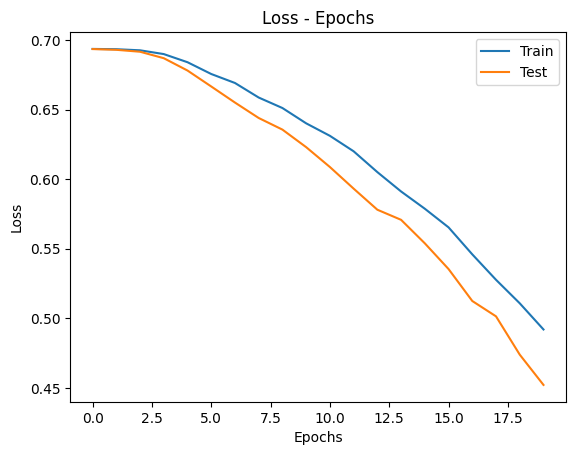

In [ ]:
plot_model_metrics(mean_loss_train, mean_loss_test)

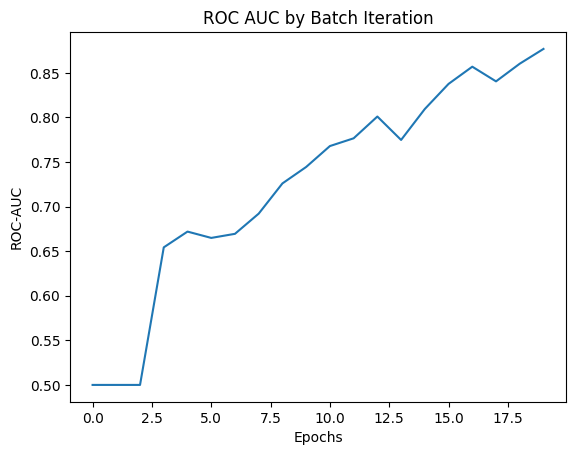

In [ ]:
plt.title('ROC AUC by Batch Iteration')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.plot(mean_auc_test)
plt.show()

In [ ]:
valid_total_loader = get_loader_from_dataset(X_valid, y_valid, batch_size = len(y_valid))

In [ ]:
# set model to evaluation mode
model.eval()

# turn off gradients for evaluation
with torch.no_grad():

    # loop over test data
    for final_images, percentual_areas, dmaxs, dmins, num_objs, targets in valid_total_loader:
      
        # move data to device
        final_images, percentual_areas = final_images.to(device), percentual_areas.to(device)
        dmaxs, dmins = dmaxs.to(device), dmins.to(device)
        num_objs, targets = num_objs.to(device), targets.to(device)
        
        # forward pass
        outputs = model(final_images, percentual_areas, dmaxs, dmins, num_objs, device)
        
        preds = outputs.detach().cpu().numpy()
        labels = targets.detach().cpu().numpy()

        # Getting the ROC AUC Score
        preds = [np.argmax(pred) for pred in preds]
        labels = [np.argmax(label) for label in labels]
        roc = roc_auc_score(labels,preds)
        print(f'ROC AUC:{roc}')

    
        break


ROC AUC:0.8420355731225296


This model is good for initial guess, let's optimize it!!

# Baysian Otimization

Let's do the search in the following Hyperparameters:

In [ ]:
dim_lr = Real(low=1e-7, high=1e-3, prior='log-uniform', name='lr')
dim_num_heads = Categorical(categories=[4,8,16], name='num_heads')
dim_embed_dim = Categorical(categories=[128,256,512], name='embed_dim')
dim_num_hidden_neurons = Categorical(categories=[64,128,256], name='num_hidden_neurons')
dim_num_transformer_blocks = Categorical(categories=[1,2,3], name='num_transformer_blocks')

Let's create the grid of possibilities (but only search the best ones and not all, since we're using bayesian optimization).

In [ ]:
param_grid = [  
                dim_lr,
                dim_num_heads,
                dim_embed_dim,
                dim_num_hidden_neurons,
                dim_num_transformer_blocks,
              ]

Declarating the of file that we use as backup:

In [ ]:
simulation_save_path = 'simulation.csv'
model_save_path = path.join('..','models','optimization')

Initialization of the best_roc_solution

In [ ]:
max_auc = -99999

Opening the Optimization's files:

In [ ]:
opt_loader = get_loader_from_dataset(X_opt, y_opt, batch_size = len(y_opt))

Declaring the function we want to optimize (the neural networks perfomance):

In [ ]:
@use_named_args(param_grid)
def objective(
    lr,
    num_heads,
    embed_dim,
    num_hidden_neurons,
    num_transformer_blocks,
):
    try:

      # Printing Hyperparameters
      print('lr:', lr)
      print('num_heads:', num_heads)
      print('embed_dim:', embed_dim)
      print('num_hidden_neurons:', num_hidden_neurons)
      print('num_transformer_blocks:', num_transformer_blocks)

      print()

      image_size = (88,64)
      patch_size = (8,8)
      in_channels = 1
      num_classes = 2
      num_hidden_layers = 2
      transformer_activation_function = nn.ReLU
      feedfoward_activation_function = nn.GELU
      dropout = 0.1

      
      # Initializing model 
      model = ViTSD(
                      image_size,
                      patch_size,
                      embed_dim,
                      in_channels,
                      num_classes,
                      num_heads,
                      num_hidden_neurons,
                      num_hidden_layers,
                      transformer_activation_function,
                      feedfoward_activation_function,
                      num_transformer_blocks,
                      device,
                      dropout
              )
      
      model.to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(),lr=lr)

      train_model(model,train_loader,valid_loader,n_epochs=50,optimizer=optimizer,criterion=criterion,device=device)

      # set model to evaluation mode
      model.eval()

      # turn off gradients for evaluation
      with torch.no_grad():

          # loop over test data
          for final_images, percentual_areas, dmaxs, dmins, num_objs, targets in opt_loader:
            
              # move data to device
              final_images, percentual_areas = final_images.to(device), percentual_areas.to(device)
              dmaxs, dmins = dmaxs.to(device), dmins.to(device)
              num_objs, targets = num_objs.to(device), targets.to(device)
              
              # forward pass
              outputs = model(final_images, percentual_areas, dmaxs, dmins, num_objs, device)
              
              preds = outputs.detach().cpu().numpy()
              labels = targets.detach().cpu().numpy()

              # Getting the ROC AUC Score
              preds = [np.argmax(pred) for pred in preds]
              labels = [np.argmax(label) for label in labels]
              auc = roc_auc_score(labels,preds)         
              break

      # Saving the data
      sim_data = {}

      sim_data['lr'] = lr
      sim_data['embed_dim'] = embed_dim
      sim_data['num_heads'] = num_heads
      sim_data['num_transformer_blocks'] = num_transformer_blocks
      sim_data['num_hidden_neurons'] = num_hidden_neurons
      sim_data['auc'] = auc

      sim_data = pd.DataFrame([sim_data])


      if path.isfile(simulation_save_path):

        simulation = pd.read_csv(simulation_save_path)
        simulation = simulation.append(sim_data)
        simulation.to_csv(simulation_save_path,index=False)
      else:
        sim_data.to_csv(simulation_save_path,index=False)


      global max_auc

      # Saving the best models
      if auc > max_auc:
        max_loss = auc
        torch.save(model.state_dict(), path.join(model_save_path,f'best_model_{int(lr*1e7)}_{embed_dim}_{num_heads}_{num_transformer_blocks}_{num_hidden_neurons}_{int(10000*auc)}.pth'))


      print()
      print("AUC: {0:.4}".format(auc))
      print()

      del model

      return -auc

    except:
      return 99999

In [ ]:
fm_ = gbrt_minimize(
    objective,  
    param_grid,  
    x0=[5e-5,8,512,128,1],  
    acq_func='EI',  
    n_calls=70,  # Num samples to run
    random_state=2023,
)

lr: 5e-05
num_heads: 8
embed_dim: 512
num_hidden_neurons: 128
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6858, Valid Loss: 0.6594, Valid AUC: 0.6442
Epoch 1/50, Train Loss: 0.6318, Valid Loss: 0.5891, Valid AUC: 0.6985
Epoch 2/50, Train Loss: 0.5727, Valid Loss: 0.5297, Valid AUC: 0.7798
Epoch 3/50, Train Loss: 0.5286, Valid Loss: 0.4906, Valid AUC: 0.8229
Epoch 4/50, Train Loss: 0.4968, Valid Loss: 0.4773, Valid AUC: 0.8296
Epoch 5/50, Train Loss: 0.4798, Valid Loss: 0.4546, Valid AUC: 0.8528
Epoch 6/50, Train Loss: 0.4770, Valid Loss: 0.4498, Valid AUC: 0.8565
Epoch 7/50, Train Loss: 0.4617, Valid Loss: 0.4356, Valid AUC: 0.8702
Epoch 8/50, Train Loss: 0.4501, Valid Loss: 0.4262, Valid AUC: 0.8822
Epoch 9/50, Train Loss: 0.4394, Valid Loss: 0.4208, Valid AUC: 0.8875
Epoch 10/50, Train Loss: 0.4314, Valid Loss: 0.4171, Valid AUC: 0.8907
Epoch 11/50, Train Loss: 0.4247, Valid Loss: 0.4162, Valid AUC: 0.8900
Epoch 12/50, Train Loss: 0.4221, Valid Loss: 0.4043, Valid AUC: 0.908

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.9005

lr: 1.9406768084463746e-06
num_heads: 16
embed_dim: 256
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6934, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6925, Valid Loss: 0.6919, Valid AUC: 0.5594
Epoch 2/50, Train Loss: 0.6914, Valid Loss: 0.6905, Valid AUC: 0.5864
Epoch 3/50, Train Loss: 0.6900, Valid Loss: 0.6885, Valid AUC: 0.5951
Epoch 4/50, Train Loss: 0.6878, Valid Loss: 0.6862, Valid AUC: 0.5954
Epoch 5/50, Train Loss: 0.6852, Valid Loss: 0.6833, Valid AUC: 0.6098
Epoch 6/50, Train Loss: 0.6826, Valid Loss: 0.6803, Valid AUC: 0.6240
Epoch 7/50, Train Loss: 0.6801, Valid Loss: 0.6773, Valid AUC: 0.6350
Epoch 8/50, Train Loss: 0.6762, Valid Loss: 0.6739, Valid AUC: 0.6379
Epoch 9/50, Train Loss: 0.6750, Valid Loss: 0.6711, Valid AUC: 0.6460
Epoch 10/50, Train Loss: 0.6713, Valid Loss: 0.6682, Valid AUC: 0.6529
Epoch 11/50, Train Loss: 0.6687, Valid Loss: 0.6652, Valid AUC: 0.6571
Epoch 12/50, Train Loss: 0.6666, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


Epoch 0/50, Train Loss: 0.6919, Valid Loss: 0.6890, Valid AUC: 0.5454
Epoch 1/50, Train Loss: 0.6789, Valid Loss: 0.6601, Valid AUC: 0.6438
Epoch 2/50, Train Loss: 0.6547, Valid Loss: 0.6311, Valid AUC: 0.6722
Epoch 3/50, Train Loss: 0.6316, Valid Loss: 0.6078, Valid AUC: 0.6974
Epoch 4/50, Train Loss: 0.6084, Valid Loss: 0.5858, Valid AUC: 0.7261
Epoch 5/50, Train Loss: 0.5927, Valid Loss: 0.5671, Valid AUC: 0.7507
Epoch 6/50, Train Loss: 0.5749, Valid Loss: 0.5489, Valid AUC: 0.7725
Epoch 7/50, Train Loss: 0.5592, Valid Loss: 0.5329, Valid AUC: 0.7933
Epoch 8/50, Train Loss: 0.5446, Valid Loss: 0.5209, Valid AUC: 0.8003
Epoch 9/50, Train Loss: 0.5314, Valid Loss: 0.5057, Valid AUC: 0.8173
Epoch 10/50, Train Loss: 0.5193, Valid Loss: 0.4982, Valid AUC: 0.8218
Epoch 11/50, Train Loss: 0.5091, Valid Loss: 0.4903, Valid AUC: 0.8247
Epoch 12/50, Train Loss: 0.4990, Valid Loss: 0.4802, Valid AUC: 0.8375
Epoch 13/50, Train Loss: 0.4932, Valid Loss: 0.4748, Valid AUC: 0.8383
Epoch 14/50, Tra

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8819

lr: 6.691030995427891e-06
num_heads: 8
embed_dim: 256
num_hidden_neurons: 64
num_transformer_blocks: 2

Epoch 0/50, Train Loss: 0.6931, Valid Loss: 0.6925, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6916, Valid Loss: 0.6900, Valid AUC: 0.5508
Epoch 2/50, Train Loss: 0.6881, Valid Loss: 0.6851, Valid AUC: 0.5788
Epoch 3/50, Train Loss: 0.6827, Valid Loss: 0.6773, Valid AUC: 0.6113
Epoch 4/50, Train Loss: 0.6738, Valid Loss: 0.6644, Valid AUC: 0.6430
Epoch 5/50, Train Loss: 0.6627, Valid Loss: 0.6496, Valid AUC: 0.6633
Epoch 6/50, Train Loss: 0.6491, Valid Loss: 0.6347, Valid AUC: 0.6769
Epoch 7/50, Train Loss: 0.6370, Valid Loss: 0.6211, Valid AUC: 0.6873
Epoch 8/50, Train Loss: 0.6277, Valid Loss: 0.6097, Valid AUC: 0.7036
Epoch 9/50, Train Loss: 0.6158, Valid Loss: 0.5979, Valid AUC: 0.7186
Epoch 10/50, Train Loss: 0.6054, Valid Loss: 0.5870, Valid AUC: 0.7274
Epoch 11/50, Train Loss: 0.5973, Valid Loss: 0.5768, Valid AUC: 0.7378
Epoch 12/50, Train Loss: 0.5883, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8518

lr: 4.449467382637479e-07
num_heads: 8
embed_dim: 128
num_hidden_neurons: 128
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6932, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6932, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6931, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6930, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6930, Valid Loss: 0.6929, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6929, Valid Loss: 0.6929, Valid AUC: 0.5017
Epoch 6/50, Train Loss: 0.6929, Valid Loss: 0.6928, Valid AUC: 0.5118
Epoch 7/50, Train Loss: 0.6928, Valid Loss: 0.6928, Valid AUC: 0.5230
Epoch 8/50, Train Loss: 0.6928, Valid Loss: 0.6927, Valid AUC: 0.5350
Epoch 9/50, Train Loss: 0.6927, Valid Loss: 0.6926, Valid AUC: 0.5556
Epoch 10/50, Train Loss: 0.6926, Valid Loss: 0.6925, Valid AUC: 0.5689
Epoch 11/50, Train Loss: 0.6925, Valid Loss: 0.6924, Valid AUC: 0.5755
Epoch 12/50, Train Loss: 0.6923, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


Epoch 0/50, Train Loss: 0.6915, Valid Loss: 0.6878, Valid AUC: 0.5719
Epoch 1/50, Train Loss: 0.6777, Valid Loss: 0.6597, Valid AUC: 0.6522
Epoch 2/50, Train Loss: 0.6463, Valid Loss: 0.6210, Valid AUC: 0.6823
Epoch 3/50, Train Loss: 0.6151, Valid Loss: 0.5892, Valid AUC: 0.7162
Epoch 4/50, Train Loss: 0.5837, Valid Loss: 0.5597, Valid AUC: 0.7577
Epoch 5/50, Train Loss: 0.5581, Valid Loss: 0.5339, Valid AUC: 0.7818
Epoch 6/50, Train Loss: 0.5376, Valid Loss: 0.5161, Valid AUC: 0.7973
Epoch 7/50, Train Loss: 0.5214, Valid Loss: 0.5005, Valid AUC: 0.8166
Epoch 8/50, Train Loss: 0.5107, Valid Loss: 0.4900, Valid AUC: 0.8254
Epoch 9/50, Train Loss: 0.4981, Valid Loss: 0.4832, Valid AUC: 0.8321
Epoch 10/50, Train Loss: 0.4876, Valid Loss: 0.4748, Valid AUC: 0.8347
Epoch 11/50, Train Loss: 0.4807, Valid Loss: 0.4646, Valid AUC: 0.8494
Epoch 12/50, Train Loss: 0.4728, Valid Loss: 0.4611, Valid AUC: 0.8505
Epoch 13/50, Train Loss: 0.4679, Valid Loss: 0.4498, Valid AUC: 0.8656
Epoch 14/50, Tra

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


Epoch 0/50, Train Loss: 0.6933, Valid Loss: 0.6933, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6933, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6933, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6932, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6932, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6932, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 6/50, Train Loss: 0.6932, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 7/50, Train Loss: 0.6932, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 8/50, Train Loss: 0.6931, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 9/50, Train Loss: 0.6931, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 10/50, Train Loss: 0.6931, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 11/50, Train Loss: 0.6931, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 12/50, Train Loss: 0.6931, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 13/50, Train Loss: 0.6930, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 14/50, Tra

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


Epoch 0/50, Train Loss: 0.6820, Valid Loss: 0.6216, Valid AUC: 0.6566
Epoch 1/50, Train Loss: 0.5958, Valid Loss: 0.5596, Valid AUC: 0.7329
Epoch 2/50, Train Loss: 0.5319, Valid Loss: 0.5151, Valid AUC: 0.7786
Epoch 3/50, Train Loss: 0.5029, Valid Loss: 0.4806, Valid AUC: 0.8180
Epoch 4/50, Train Loss: 0.4839, Valid Loss: 0.4985, Valid AUC: 0.7998
Epoch 5/50, Train Loss: 0.4865, Valid Loss: 0.4547, Valid AUC: 0.8517
Epoch 6/50, Train Loss: 0.4727, Valid Loss: 0.4559, Valid AUC: 0.8496
Epoch 7/50, Train Loss: 0.4598, Valid Loss: 0.4543, Valid AUC: 0.8486
Epoch 8/50, Train Loss: 0.4634, Valid Loss: 0.4422, Valid AUC: 0.8629
Epoch 9/50, Train Loss: 0.4583, Valid Loss: 0.4494, Valid AUC: 0.8539
Epoch 10/50, Train Loss: 0.4503, Valid Loss: 0.4349, Valid AUC: 0.8669
Epoch 11/50, Train Loss: 0.4353, Valid Loss: 0.4300, Valid AUC: 0.8750
Epoch 12/50, Train Loss: 0.4347, Valid Loss: 0.4232, Valid AUC: 0.8833
Epoch 13/50, Train Loss: 0.4326, Valid Loss: 0.4105, Valid AUC: 0.8970
Epoch 14/50, Tra

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8974

lr: 0.0008360435545349246
num_heads: 16
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6970, Valid Loss: 0.6921, Valid AUC: 0.5008
Epoch 1/50, Train Loss: 0.6709, Valid Loss: 0.6124, Valid AUC: 0.6781
Epoch 2/50, Train Loss: 0.5966, Valid Loss: 0.5550, Valid AUC: 0.7490
Epoch 3/50, Train Loss: 0.5587, Valid Loss: 0.5333, Valid AUC: 0.7575
Epoch 4/50, Train Loss: 0.5209, Valid Loss: 0.4935, Valid AUC: 0.8032
Epoch 5/50, Train Loss: 0.5106, Valid Loss: 0.4940, Valid AUC: 0.8089
Epoch 6/50, Train Loss: 0.5048, Valid Loss: 0.4918, Valid AUC: 0.8083
Epoch 7/50, Train Loss: 0.4916, Valid Loss: 0.4732, Valid AUC: 0.8272
Epoch 8/50, Train Loss: 0.4821, Valid Loss: 0.5095, Valid AUC: 0.7913
Epoch 9/50, Train Loss: 0.4788, Valid Loss: 0.5179, Valid AUC: 0.7807
Epoch 10/50, Train Loss: 0.4917, Valid Loss: 0.4614, Valid AUC: 0.8389
Epoch 11/50, Train Loss: 0.4668, Valid Loss: 0.4600, Valid AUC: 0.8451
Epoch 12/50, Train Loss: 0.4685, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


Epoch 0/50, Train Loss: 0.6934, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6930, Valid Loss: 0.6927, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6925, Valid Loss: 0.6920, Valid AUC: 0.5247
Epoch 3/50, Train Loss: 0.6918, Valid Loss: 0.6912, Valid AUC: 0.5897
Epoch 4/50, Train Loss: 0.6910, Valid Loss: 0.6902, Valid AUC: 0.5994
Epoch 5/50, Train Loss: 0.6900, Valid Loss: 0.6890, Valid AUC: 0.6009
Epoch 6/50, Train Loss: 0.6890, Valid Loss: 0.6877, Valid AUC: 0.6021
Epoch 7/50, Train Loss: 0.6877, Valid Loss: 0.6861, Valid AUC: 0.6046
Epoch 8/50, Train Loss: 0.6857, Valid Loss: 0.6843, Valid AUC: 0.6085
Epoch 9/50, Train Loss: 0.6836, Valid Loss: 0.6823, Valid AUC: 0.6189
Epoch 10/50, Train Loss: 0.6816, Valid Loss: 0.6801, Valid AUC: 0.6209
Epoch 11/50, Train Loss: 0.6795, Valid Loss: 0.6778, Valid AUC: 0.6227
Epoch 12/50, Train Loss: 0.6776, Valid Loss: 0.6754, Valid AUC: 0.6255
Epoch 13/50, Train Loss: 0.6754, Valid Loss: 0.6730, Valid AUC: 0.6298
Epoch 14/50, Tra

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.7277

lr: 0.000774700267670814
num_heads: 8
embed_dim: 512
num_hidden_neurons: 128
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.7032, Valid Loss: 0.6986, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6970, Valid Loss: 0.6940, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6943, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6939, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6934, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6925, Valid Loss: 0.6914, Valid AUC: 0.5558
Epoch 6/50, Train Loss: 0.6888, Valid Loss: 0.6859, Valid AUC: 0.5703
Epoch 7/50, Train Loss: 0.6837, Valid Loss: 0.6821, Valid AUC: 0.5735
Epoch 8/50, Train Loss: 0.6795, Valid Loss: 0.6783, Valid AUC: 0.5827
Epoch 9/50, Train Loss: 0.6761, Valid Loss: 0.6775, Valid AUC: 0.5690
Epoch 10/50, Train Loss: 0.6757, Valid Loss: 0.6749, Valid AUC: 0.5798
Epoch 11/50, Train Loss: 0.6735, Valid Loss: 0.6738, Valid AUC: 0.5826
Epoch 12/50, Train Loss: 0.6734, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.6173

lr: 5.4475545531700904e-05
num_heads: 8
embed_dim: 512
num_hidden_neurons: 128
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6856, Valid Loss: 0.6558, Valid AUC: 0.6400
Epoch 1/50, Train Loss: 0.6249, Valid Loss: 0.5758, Valid AUC: 0.7165
Epoch 2/50, Train Loss: 0.5636, Valid Loss: 0.5169, Valid AUC: 0.7897
Epoch 3/50, Train Loss: 0.5251, Valid Loss: 0.4940, Valid AUC: 0.8093
Epoch 4/50, Train Loss: 0.4969, Valid Loss: 0.4683, Valid AUC: 0.8386
Epoch 5/50, Train Loss: 0.4858, Valid Loss: 0.4552, Valid AUC: 0.8502
Epoch 6/50, Train Loss: 0.4633, Valid Loss: 0.4374, Valid AUC: 0.8724
Epoch 7/50, Train Loss: 0.4507, Valid Loss: 0.4265, Valid AUC: 0.8843
Epoch 8/50, Train Loss: 0.4477, Valid Loss: 0.4205, Valid AUC: 0.8887
Epoch 9/50, Train Loss: 0.4423, Valid Loss: 0.4273, Valid AUC: 0.8763
Epoch 10/50, Train Loss: 0.4351, Valid Loss: 0.4053, Valid AUC: 0.9065
Epoch 11/50, Train Loss: 0.4192, Valid Loss: 0.4062, Valid AUC: 0.9057
Epoch 12/50, Train Loss: 0.4233, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8884

lr: 1.243229680662625e-05
num_heads: 4
embed_dim: 128
num_hidden_neurons: 128
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6927, Valid Loss: 0.6911, Valid AUC: 0.5610
Epoch 1/50, Train Loss: 0.6875, Valid Loss: 0.6814, Valid AUC: 0.5784
Epoch 2/50, Train Loss: 0.6700, Valid Loss: 0.6529, Valid AUC: 0.6513
Epoch 3/50, Train Loss: 0.6403, Valid Loss: 0.6204, Valid AUC: 0.6813
Epoch 4/50, Train Loss: 0.6151, Valid Loss: 0.5965, Valid AUC: 0.7086
Epoch 5/50, Train Loss: 0.5950, Valid Loss: 0.5748, Valid AUC: 0.7327
Epoch 6/50, Train Loss: 0.5741, Valid Loss: 0.5540, Valid AUC: 0.7613
Epoch 7/50, Train Loss: 0.5568, Valid Loss: 0.5362, Valid AUC: 0.7822
Epoch 8/50, Train Loss: 0.5429, Valid Loss: 0.5225, Valid AUC: 0.7969
Epoch 9/50, Train Loss: 0.5288, Valid Loss: 0.5102, Valid AUC: 0.8062
Epoch 10/50, Train Loss: 0.5183, Valid Loss: 0.5019, Valid AUC: 0.8167
Epoch 11/50, Train Loss: 0.5098, Valid Loss: 0.4906, Valid AUC: 0.8248
Epoch 12/50, Train Loss: 0.5022, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.00041377021196607874
num_heads: 8
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.6971, Valid Loss: 0.6953, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6957, Valid Loss: 0.6943, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6936, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6947, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6941, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6935, Valid Loss: 0.6940, Valid AUC: 0.5000
Epoch 6/50, Train Loss: 0.6941, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 7/50, Train Loss: 0.6934, Valid Loss: 0.6933, Valid AUC: 0.5000
Epoch 8/50, Train Loss: 0.6933, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 9/50, Train Loss: 0.6930, Valid Loss: 0.6929, Valid AUC: 0.5002
Epoch 10/50, Train Loss: 0.6927, Valid Loss: 0.6927, Valid AUC: 0.5217
Epoch 11/50, Train Loss: 0.6926, Valid Loss: 0.6923, Valid AUC: 0.5492
Epoch 12/50, Train Loss: 0.6920, Valid Loss: 0.6917, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.5787

lr: 1.7672467464836052e-05
num_heads: 4
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.6938, Valid Loss: 0.6914, Valid AUC: 0.5578
Epoch 1/50, Train Loss: 0.6891, Valid Loss: 0.6838, Valid AUC: 0.5943
Epoch 2/50, Train Loss: 0.6762, Valid Loss: 0.6593, Valid AUC: 0.6473
Epoch 3/50, Train Loss: 0.6548, Valid Loss: 0.6336, Valid AUC: 0.6701
Epoch 4/50, Train Loss: 0.6352, Valid Loss: 0.6126, Valid AUC: 0.6915
Epoch 5/50, Train Loss: 0.6185, Valid Loss: 0.5922, Valid AUC: 0.7173
Epoch 6/50, Train Loss: 0.6009, Valid Loss: 0.5724, Valid AUC: 0.7465
Epoch 7/50, Train Loss: 0.5819, Valid Loss: 0.5549, Valid AUC: 0.7657
Epoch 8/50, Train Loss: 0.5674, Valid Loss: 0.5415, Valid AUC: 0.7764
Epoch 9/50, Train Loss: 0.5516, Valid Loss: 0.5276, Valid AUC: 0.7880
Epoch 10/50, Train Loss: 0.5398, Valid Loss: 0.5118, Valid AUC: 0.8062
Epoch 11/50, Train Loss: 0.5272, Valid Loss: 0.5018, Valid AUC: 0.8113
Epoch 12/50, Train Loss: 0.5181, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 3.27129032842699e-05
num_heads: 8
embed_dim: 512
num_hidden_neurons: 128
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6879, Valid Loss: 0.6686, Valid AUC: 0.6269
Epoch 1/50, Train Loss: 0.6440, Valid Loss: 0.6071, Valid AUC: 0.6797
Epoch 2/50, Train Loss: 0.5919, Valid Loss: 0.5534, Valid AUC: 0.7543
Epoch 3/50, Train Loss: 0.5484, Valid Loss: 0.5162, Valid AUC: 0.7927
Epoch 4/50, Train Loss: 0.5201, Valid Loss: 0.4895, Valid AUC: 0.8212
Epoch 5/50, Train Loss: 0.5034, Valid Loss: 0.4755, Valid AUC: 0.8338
Epoch 6/50, Train Loss: 0.4905, Valid Loss: 0.4677, Valid AUC: 0.8411
Epoch 7/50, Train Loss: 0.4716, Valid Loss: 0.4528, Valid AUC: 0.8531
Epoch 8/50, Train Loss: 0.4627, Valid Loss: 0.4428, Valid AUC: 0.8634
Epoch 9/50, Train Loss: 0.4560, Valid Loss: 0.4366, Valid AUC: 0.8713
Epoch 10/50, Train Loss: 0.4493, Valid Loss: 0.4274, Valid AUC: 0.8806
Epoch 11/50, Train Loss: 0.4411, Valid Loss: 0.4271, Valid AUC: 0.8820
Epoch 12/50, Train Loss: 0.4391, Valid Loss: 0.4226, V

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8914

lr: 4.9675219540504883e-05
num_heads: 8
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.6828, Valid Loss: 0.6368, Valid AUC: 0.6506
Epoch 1/50, Train Loss: 0.6061, Valid Loss: 0.5468, Valid AUC: 0.7457
Epoch 2/50, Train Loss: 0.5369, Valid Loss: 0.5418, Valid AUC: 0.7474
Epoch 3/50, Train Loss: 0.5038, Valid Loss: 0.5125, Valid AUC: 0.7786
Epoch 4/50, Train Loss: 0.4862, Valid Loss: 0.4533, Valid AUC: 0.8500
Epoch 5/50, Train Loss: 0.4735, Valid Loss: 0.4443, Valid AUC: 0.8631
Epoch 6/50, Train Loss: 0.4661, Valid Loss: 0.4428, Valid AUC: 0.8592
Epoch 7/50, Train Loss: 0.4452, Valid Loss: 0.4283, Valid AUC: 0.8751
Epoch 8/50, Train Loss: 0.4534, Valid Loss: 0.4243, Valid AUC: 0.8842
Epoch 9/50, Train Loss: 0.4460, Valid Loss: 0.4247, Valid AUC: 0.8797
Epoch 10/50, Train Loss: 0.4448, Valid Loss: 0.4455, Valid AUC: 0.8603
Epoch 11/50, Train Loss: 0.4329, Valid Loss: 0.4575, Valid AUC: 0.8471
Epoch 12/50, Train Loss: 0.4209, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.9026

lr: 0.0009438683102893268
num_heads: 16
embed_dim: 256
num_hidden_neurons: 64
num_transformer_blocks: 2

Epoch 0/50, Train Loss: 0.6966, Valid Loss: 0.6934, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6945, Valid Loss: 0.6934, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6935, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6934, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6928, Valid Loss: 0.6924, Valid AUC: 0.5500
Epoch 5/50, Train Loss: 0.6912, Valid Loss: 0.6892, Valid AUC: 0.5544
Epoch 6/50, Train Loss: 0.6867, Valid Loss: 0.6842, Valid AUC: 0.5734
Epoch 7/50, Train Loss: 0.6824, Valid Loss: 0.6802, Valid AUC: 0.5776
Epoch 8/50, Train Loss: 0.6775, Valid Loss: 0.6767, Valid AUC: 0.5721
Epoch 9/50, Train Loss: 0.6753, Valid Loss: 0.6739, Valid AUC: 0.5881
Epoch 10/50, Train Loss: 0.6732, Valid Loss: 0.6735, Valid AUC: 0.5825
Epoch 11/50, Train Loss: 0.6722, Valid Loss: 0.6716, Valid AUC: 0.5889
Epoch 12/50, Train Loss: 0.6726, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.6022

lr: 0.0008917055929712475
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6986, Valid Loss: 0.6931, Valid AUC: 0.5159
Epoch 1/50, Train Loss: 0.6942, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6937, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6932, Valid Loss: 0.6907, Valid AUC: 0.5688
Epoch 4/50, Train Loss: 0.6818, Valid Loss: 0.6365, Valid AUC: 0.6163
Epoch 5/50, Train Loss: 0.6129, Valid Loss: 0.5982, Valid AUC: 0.6926
Epoch 6/50, Train Loss: 0.5762, Valid Loss: 0.6517, Valid AUC: 0.6304
Epoch 7/50, Train Loss: 0.5457, Valid Loss: 0.5408, Valid AUC: 0.7467
Epoch 8/50, Train Loss: 0.5114, Valid Loss: 0.5506, Valid AUC: 0.7477
Epoch 9/50, Train Loss: 0.5057, Valid Loss: 0.4758, Valid AUC: 0.8223
Epoch 10/50, Train Loss: 0.5027, Valid Loss: 0.4663, Valid AUC: 0.8362
Epoch 11/50, Train Loss: 0.4840, Valid Loss: 0.4501, Valid AUC: 0.8546
Epoch 12/50, Train Loss: 0.4822, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.0009422712326578618
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.6976, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6948, Valid Loss: 0.6935, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6939, Valid Loss: 0.6942, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6936, Valid Loss: 0.6929, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6920, Valid Loss: 0.6894, Valid AUC: 0.5637
Epoch 5/50, Train Loss: 0.6867, Valid Loss: 0.6844, Valid AUC: 0.5587
Epoch 6/50, Train Loss: 0.6795, Valid Loss: 0.6736, Valid AUC: 0.5814
Epoch 7/50, Train Loss: 0.6748, Valid Loss: 0.6714, Valid AUC: 0.5875
Epoch 8/50, Train Loss: 0.6731, Valid Loss: 0.6699, Valid AUC: 0.5847
Epoch 9/50, Train Loss: 0.6718, Valid Loss: 0.6690, Valid AUC: 0.5850
Epoch 10/50, Train Loss: 0.6712, Valid Loss: 0.6686, Valid AUC: 0.5870
Epoch 11/50, Train Loss: 0.6707, Valid Loss: 0.6680, Valid AUC: 0.5892
Epoch 12/50, Train Loss: 0.6705, Valid Loss: 0.6681, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.6825

lr: 0.00023841223033857367
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6653, Valid Loss: 0.5961, Valid AUC: 0.6907
Epoch 1/50, Train Loss: 0.5681, Valid Loss: 0.6082, Valid AUC: 0.6683
Epoch 2/50, Train Loss: 0.5282, Valid Loss: 0.5374, Valid AUC: 0.7569
Epoch 3/50, Train Loss: 0.5091, Valid Loss: 0.4800, Valid AUC: 0.8147
Epoch 4/50, Train Loss: 0.4900, Valid Loss: 0.5348, Valid AUC: 0.7622
Epoch 5/50, Train Loss: 0.5057, Valid Loss: 0.4599, Valid AUC: 0.8422
Epoch 6/50, Train Loss: 0.4820, Valid Loss: 0.4484, Valid AUC: 0.8505
Epoch 7/50, Train Loss: 0.4655, Valid Loss: 0.4604, Valid AUC: 0.8391
Epoch 8/50, Train Loss: 0.4889, Valid Loss: 0.5002, Valid AUC: 0.8030
Epoch 9/50, Train Loss: 0.4567, Valid Loss: 0.4612, Valid AUC: 0.8419
Epoch 10/50, Train Loss: 0.4509, Valid Loss: 0.4376, Valid AUC: 0.8673
Epoch 11/50, Train Loss: 0.4437, Valid Loss: 0.4377, Valid AUC: 0.8681
Epoch 12/50, Train Loss: 0.4460, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8953

lr: 0.0008562102782903563
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6970, Valid Loss: 0.6914, Valid AUC: 0.5153
Epoch 1/50, Train Loss: 0.6640, Valid Loss: 0.6178, Valid AUC: 0.6521
Epoch 2/50, Train Loss: 0.5943, Valid Loss: 0.5369, Valid AUC: 0.7519
Epoch 3/50, Train Loss: 0.5381, Valid Loss: 0.5100, Valid AUC: 0.7846
Epoch 4/50, Train Loss: 0.5192, Valid Loss: 0.5025, Valid AUC: 0.7901
Epoch 5/50, Train Loss: 0.5165, Valid Loss: 0.4829, Valid AUC: 0.8153
Epoch 6/50, Train Loss: 0.5271, Valid Loss: 0.5317, Valid AUC: 0.7693
Epoch 7/50, Train Loss: 0.5047, Valid Loss: 0.4681, Valid AUC: 0.8336
Epoch 8/50, Train Loss: 0.4821, Valid Loss: 0.4544, Valid AUC: 0.8501
Epoch 9/50, Train Loss: 0.4882, Valid Loss: 0.4646, Valid AUC: 0.8378
Epoch 10/50, Train Loss: 0.4767, Valid Loss: 0.4642, Valid AUC: 0.8361
Epoch 11/50, Train Loss: 0.4801, Valid Loss: 0.4935, Valid AUC: 0.8066
Epoch 12/50, Train Loss: 0.4649, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8829

lr: 0.0004836783776505763
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6840, Valid Loss: 0.6123, Valid AUC: 0.6630
Epoch 1/50, Train Loss: 0.5940, Valid Loss: 0.5362, Valid AUC: 0.7584
Epoch 2/50, Train Loss: 0.5340, Valid Loss: 0.5134, Valid AUC: 0.7794
Epoch 3/50, Train Loss: 0.5253, Valid Loss: 0.4871, Valid AUC: 0.8117
Epoch 4/50, Train Loss: 0.5031, Valid Loss: 0.5067, Valid AUC: 0.7960
Epoch 5/50, Train Loss: 0.4969, Valid Loss: 0.4886, Valid AUC: 0.8059
Epoch 6/50, Train Loss: 0.4803, Valid Loss: 0.4769, Valid AUC: 0.8216
Epoch 7/50, Train Loss: 0.4651, Valid Loss: 0.4936, Valid AUC: 0.8076
Epoch 8/50, Train Loss: 0.4803, Valid Loss: 0.4821, Valid AUC: 0.8174
Epoch 9/50, Train Loss: 0.4805, Valid Loss: 0.4722, Valid AUC: 0.8292
Epoch 10/50, Train Loss: 0.4571, Valid Loss: 0.4352, Valid AUC: 0.8704
Epoch 11/50, Train Loss: 0.4535, Valid Loss: 0.4780, Valid AUC: 0.8257
Epoch 12/50, Train Loss: 0.4612, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.0008391351347557786
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6940, Valid Loss: 0.6531, Valid AUC: 0.6215
Epoch 1/50, Train Loss: 0.6223, Valid Loss: 0.5665, Valid AUC: 0.7282
Epoch 2/50, Train Loss: 0.5634, Valid Loss: 0.5452, Valid AUC: 0.7451
Epoch 3/50, Train Loss: 0.5370, Valid Loss: 0.5436, Valid AUC: 0.7453
Epoch 4/50, Train Loss: 0.5257, Valid Loss: 0.4807, Valid AUC: 0.8191
Epoch 5/50, Train Loss: 0.5022, Valid Loss: 0.5498, Valid AUC: 0.7429
Epoch 6/50, Train Loss: 0.5277, Valid Loss: 0.5816, Valid AUC: 0.7123
Epoch 7/50, Train Loss: 0.5017, Valid Loss: 0.4598, Valid AUC: 0.8474
Epoch 8/50, Train Loss: 0.5027, Valid Loss: 0.5238, Valid AUC: 0.7730
Epoch 9/50, Train Loss: 0.4766, Valid Loss: 0.4450, Valid AUC: 0.8570
Epoch 10/50, Train Loss: 0.4682, Valid Loss: 0.4618, Valid AUC: 0.8401
Epoch 11/50, Train Loss: 0.4660, Valid Loss: 0.4708, Valid AUC: 0.8304
Epoch 12/50, Train Loss: 0.4692, Valid Loss: 0.4854, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.0003541274434049111
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6730, Valid Loss: 0.6264, Valid AUC: 0.6421
Epoch 1/50, Train Loss: 0.5682, Valid Loss: 0.5563, Valid AUC: 0.7320
Epoch 2/50, Train Loss: 0.5307, Valid Loss: 0.5310, Valid AUC: 0.7615
Epoch 3/50, Train Loss: 0.5059, Valid Loss: 0.4914, Valid AUC: 0.8091
Epoch 4/50, Train Loss: 0.4996, Valid Loss: 0.5211, Valid AUC: 0.7753
Epoch 5/50, Train Loss: 0.4943, Valid Loss: 0.5082, Valid AUC: 0.7907
Epoch 6/50, Train Loss: 0.4852, Valid Loss: 0.4613, Valid AUC: 0.8409
Epoch 7/50, Train Loss: 0.4702, Valid Loss: 0.4602, Valid AUC: 0.8448
Epoch 8/50, Train Loss: 0.4641, Valid Loss: 0.4768, Valid AUC: 0.8227
Epoch 9/50, Train Loss: 0.4674, Valid Loss: 0.4551, Valid AUC: 0.8468
Epoch 10/50, Train Loss: 0.4518, Valid Loss: 0.4503, Valid AUC: 0.8540
Epoch 11/50, Train Loss: 0.4751, Valid Loss: 0.4617, Valid AUC: 0.8411
Epoch 12/50, Train Loss: 0.4546, Valid Loss: 0.4614, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 1.8058988369664353e-05
num_heads: 8
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.6900, Valid Loss: 0.6724, Valid AUC: 0.6053
Epoch 1/50, Train Loss: 0.6489, Valid Loss: 0.6046, Valid AUC: 0.6824
Epoch 2/50, Train Loss: 0.5917, Valid Loss: 0.5487, Valid AUC: 0.7515
Epoch 3/50, Train Loss: 0.5496, Valid Loss: 0.5099, Valid AUC: 0.7983
Epoch 4/50, Train Loss: 0.5221, Valid Loss: 0.4926, Valid AUC: 0.8164
Epoch 5/50, Train Loss: 0.4995, Valid Loss: 0.4781, Valid AUC: 0.8289
Epoch 6/50, Train Loss: 0.4846, Valid Loss: 0.4554, Valid AUC: 0.8522
Epoch 7/50, Train Loss: 0.4708, Valid Loss: 0.4474, Valid AUC: 0.8600
Epoch 8/50, Train Loss: 0.4629, Valid Loss: 0.4434, Valid AUC: 0.8655
Epoch 9/50, Train Loss: 0.4581, Valid Loss: 0.4353, Valid AUC: 0.8719
Epoch 10/50, Train Loss: 0.4460, Valid Loss: 0.4260, Valid AUC: 0.8837
Epoch 11/50, Train Loss: 0.4418, Valid Loss: 0.4211, Valid AUC: 0.8877
Epoch 12/50, Train Loss: 0.4382, Valid Loss: 0.4279,

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8988

lr: 0.00046136873335570296
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6876, Valid Loss: 0.6354, Valid AUC: 0.6461
Epoch 1/50, Train Loss: 0.5983, Valid Loss: 0.5658, Valid AUC: 0.7236
Epoch 2/50, Train Loss: 0.5396, Valid Loss: 0.5393, Valid AUC: 0.7539
Epoch 3/50, Train Loss: 0.5215, Valid Loss: 0.4944, Valid AUC: 0.8024
Epoch 4/50, Train Loss: 0.5052, Valid Loss: 0.4881, Valid AUC: 0.8119
Epoch 5/50, Train Loss: 0.4997, Valid Loss: 0.4894, Valid AUC: 0.8092
Epoch 6/50, Train Loss: 0.5093, Valid Loss: 0.5532, Valid AUC: 0.7338
Epoch 7/50, Train Loss: 0.4882, Valid Loss: 0.4587, Valid AUC: 0.8487
Epoch 8/50, Train Loss: 0.4712, Valid Loss: 0.4540, Valid AUC: 0.8483
Epoch 9/50, Train Loss: 0.4743, Valid Loss: 0.4699, Valid AUC: 0.8327
Epoch 10/50, Train Loss: 0.4765, Valid Loss: 0.5015, Valid AUC: 0.8033
Epoch 11/50, Train Loss: 0.4620, Valid Loss: 0.4439, Valid AUC: 0.8593
Epoch 12/50, Train Loss: 0.4523, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.0009783274091444971
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6964, Valid Loss: 0.6694, Valid AUC: 0.6209
Epoch 1/50, Train Loss: 0.6367, Valid Loss: 0.5969, Valid AUC: 0.7128
Epoch 2/50, Train Loss: 0.5730, Valid Loss: 0.5240, Valid AUC: 0.7648
Epoch 3/50, Train Loss: 0.5319, Valid Loss: 0.5456, Valid AUC: 0.7507
Epoch 4/50, Train Loss: 0.5296, Valid Loss: 0.4813, Valid AUC: 0.8200
Epoch 5/50, Train Loss: 0.5211, Valid Loss: 0.4848, Valid AUC: 0.8171
Epoch 6/50, Train Loss: 0.4963, Valid Loss: 0.4924, Valid AUC: 0.8039
Epoch 7/50, Train Loss: 0.4856, Valid Loss: 0.4793, Valid AUC: 0.8230
Epoch 8/50, Train Loss: 0.4842, Valid Loss: 0.4735, Valid AUC: 0.8243
Epoch 9/50, Train Loss: 0.4774, Valid Loss: 0.4585, Valid AUC: 0.8436
Epoch 10/50, Train Loss: 0.4660, Valid Loss: 0.4838, Valid AUC: 0.8241
Epoch 11/50, Train Loss: 0.4931, Valid Loss: 0.4604, Valid AUC: 0.8436
Epoch 12/50, Train Loss: 0.4633, Valid Loss: 0.4752, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.00014933840575349994
num_heads: 8
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.6915, Valid Loss: 0.6757, Valid AUC: 0.6265
Epoch 1/50, Train Loss: 0.6370, Valid Loss: 0.5787, Valid AUC: 0.7059
Epoch 2/50, Train Loss: 0.5564, Valid Loss: 0.5078, Valid AUC: 0.7910
Epoch 3/50, Train Loss: 0.5211, Valid Loss: 0.4816, Valid AUC: 0.8206
Epoch 4/50, Train Loss: 0.4936, Valid Loss: 0.4581, Valid AUC: 0.8446
Epoch 5/50, Train Loss: 0.4785, Valid Loss: 0.5151, Valid AUC: 0.7794
Epoch 6/50, Train Loss: 0.4838, Valid Loss: 0.4340, Valid AUC: 0.8688
Epoch 7/50, Train Loss: 0.4557, Valid Loss: 0.4541, Valid AUC: 0.8453
Epoch 8/50, Train Loss: 0.4565, Valid Loss: 0.4136, Valid AUC: 0.8900
Epoch 9/50, Train Loss: 0.4426, Valid Loss: 0.4273, Valid AUC: 0.8782
Epoch 10/50, Train Loss: 0.4476, Valid Loss: 0.5661, Valid AUC: 0.7353
Epoch 11/50, Train Loss: 0.4530, Valid Loss: 0.4289, Valid AUC: 0.8740
Epoch 12/50, Train Loss: 0.4332, Valid Loss: 0.4243, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8872

lr: 0.0005098815329295512
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6700, Valid Loss: 0.6046, Valid AUC: 0.6879
Epoch 1/50, Train Loss: 0.5771, Valid Loss: 0.6687, Valid AUC: 0.6159
Epoch 2/50, Train Loss: 0.5479, Valid Loss: 0.5089, Valid AUC: 0.7887
Epoch 3/50, Train Loss: 0.5187, Valid Loss: 0.4900, Valid AUC: 0.8103
Epoch 4/50, Train Loss: 0.5371, Valid Loss: 0.5042, Valid AUC: 0.7914
Epoch 5/50, Train Loss: 0.5026, Valid Loss: 0.4735, Valid AUC: 0.8230
Epoch 6/50, Train Loss: 0.4983, Valid Loss: 0.4831, Valid AUC: 0.8190
Epoch 7/50, Train Loss: 0.4743, Valid Loss: 0.4848, Valid AUC: 0.8137
Epoch 8/50, Train Loss: 0.4708, Valid Loss: 0.4665, Valid AUC: 0.8375
Epoch 9/50, Train Loss: 0.4579, Valid Loss: 0.4493, Valid AUC: 0.8531
Epoch 10/50, Train Loss: 0.4512, Valid Loss: 0.4747, Valid AUC: 0.8309
Epoch 11/50, Train Loss: 0.4909, Valid Loss: 0.4356, Valid AUC: 0.8714
Epoch 12/50, Train Loss: 0.4404, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.0004302265761639615
num_heads: 8
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6986, Valid Loss: 0.6708, Valid AUC: 0.5623
Epoch 1/50, Train Loss: 0.6297, Valid Loss: 0.5850, Valid AUC: 0.6984
Epoch 2/50, Train Loss: 0.5834, Valid Loss: 0.5518, Valid AUC: 0.7469
Epoch 3/50, Train Loss: 0.5387, Valid Loss: 0.5259, Valid AUC: 0.7643
Epoch 4/50, Train Loss: 0.5305, Valid Loss: 0.4888, Valid AUC: 0.8135
Epoch 5/50, Train Loss: 0.5227, Valid Loss: 0.5277, Valid AUC: 0.7664
Epoch 6/50, Train Loss: 0.5147, Valid Loss: 0.4875, Valid AUC: 0.8093
Epoch 7/50, Train Loss: 0.5194, Valid Loss: 0.5225, Valid AUC: 0.7733
Epoch 8/50, Train Loss: 0.4827, Valid Loss: 0.4863, Valid AUC: 0.8059
Epoch 9/50, Train Loss: 0.4902, Valid Loss: 0.4965, Valid AUC: 0.8058
Epoch 10/50, Train Loss: 0.5061, Valid Loss: 0.4789, Valid AUC: 0.8216
Epoch 11/50, Train Loss: 0.4818, Valid Loss: 0.4925, Valid AUC: 0.8050
Epoch 12/50, Train Loss: 0.4716, Valid Loss: 0.4461, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8575

lr: 0.0007110627980998176
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6964, Valid Loss: 0.6791, Valid AUC: 0.5967
Epoch 1/50, Train Loss: 0.6405, Valid Loss: 0.5927, Valid AUC: 0.6890
Epoch 2/50, Train Loss: 0.5709, Valid Loss: 0.5900, Valid AUC: 0.6923
Epoch 3/50, Train Loss: 0.5566, Valid Loss: 0.5407, Valid AUC: 0.7550
Epoch 4/50, Train Loss: 0.5251, Valid Loss: 0.5050, Valid AUC: 0.7916
Epoch 5/50, Train Loss: 0.5068, Valid Loss: 0.5005, Valid AUC: 0.7919
Epoch 6/50, Train Loss: 0.4983, Valid Loss: 0.5420, Valid AUC: 0.7586
Epoch 7/50, Train Loss: 0.4935, Valid Loss: 0.4808, Valid AUC: 0.8125
Epoch 8/50, Train Loss: 0.5002, Valid Loss: 0.4818, Valid AUC: 0.8209
Epoch 9/50, Train Loss: 0.4738, Valid Loss: 0.4683, Valid AUC: 0.8360
Epoch 10/50, Train Loss: 0.4726, Valid Loss: 0.4521, Valid AUC: 0.8495
Epoch 11/50, Train Loss: 0.4585, Valid Loss: 0.4687, Valid AUC: 0.8352
Epoch 12/50, Train Loss: 0.4540, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8805

lr: 0.00025621121598452226
num_heads: 8
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 2

Epoch 0/50, Train Loss: 0.6935, Valid Loss: 0.6782, Valid AUC: 0.5777
Epoch 1/50, Train Loss: 0.6372, Valid Loss: 0.5721, Valid AUC: 0.7082
Epoch 2/50, Train Loss: 0.5658, Valid Loss: 0.5530, Valid AUC: 0.7213
Epoch 3/50, Train Loss: 0.5207, Valid Loss: 0.4885, Valid AUC: 0.8065
Epoch 4/50, Train Loss: 0.5126, Valid Loss: 0.4613, Valid AUC: 0.8375
Epoch 5/50, Train Loss: 0.4840, Valid Loss: 0.4881, Valid AUC: 0.8108
Epoch 6/50, Train Loss: 0.4819, Valid Loss: 0.4505, Valid AUC: 0.8491
Epoch 7/50, Train Loss: 0.4583, Valid Loss: 0.4889, Valid AUC: 0.8125
Epoch 8/50, Train Loss: 0.4936, Valid Loss: 0.4446, Valid AUC: 0.8607
Epoch 9/50, Train Loss: 0.4657, Valid Loss: 0.4744, Valid AUC: 0.8267
Epoch 10/50, Train Loss: 0.4665, Valid Loss: 0.4447, Valid AUC: 0.8591
Epoch 11/50, Train Loss: 0.4698, Valid Loss: 0.4442, Valid AUC: 0.8612
Epoch 12/50, Train Loss: 0.4572, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8642

lr: 0.00047401533074959784
num_heads: 4
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6790, Valid Loss: 0.6162, Valid AUC: 0.6676
Epoch 1/50, Train Loss: 0.5901, Valid Loss: 0.5443, Valid AUC: 0.7409
Epoch 2/50, Train Loss: 0.5334, Valid Loss: 0.5037, Valid AUC: 0.7913
Epoch 3/50, Train Loss: 0.5066, Valid Loss: 0.5218, Valid AUC: 0.7669
Epoch 4/50, Train Loss: 0.4951, Valid Loss: 0.4804, Valid AUC: 0.8158
Epoch 5/50, Train Loss: 0.4998, Valid Loss: 0.4962, Valid AUC: 0.8015
Epoch 6/50, Train Loss: 0.4946, Valid Loss: 0.4508, Valid AUC: 0.8563
Epoch 7/50, Train Loss: 0.4738, Valid Loss: 0.4424, Valid AUC: 0.8604
Epoch 8/50, Train Loss: 0.4622, Valid Loss: 0.4549, Valid AUC: 0.8465
Epoch 9/50, Train Loss: 0.4584, Valid Loss: 0.4855, Valid AUC: 0.8168
Epoch 10/50, Train Loss: 0.4568, Valid Loss: 0.4394, Valid AUC: 0.8670
Epoch 11/50, Train Loss: 0.4459, Valid Loss: 0.4313, Valid AUC: 0.8723
Epoch 12/50, Train Loss: 0.4415, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 4.85727351801199e-05
num_heads: 8
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 2

Epoch 0/50, Train Loss: 0.6783, Valid Loss: 0.6268, Valid AUC: 0.6607
Epoch 1/50, Train Loss: 0.5969, Valid Loss: 0.5482, Valid AUC: 0.7458
Epoch 2/50, Train Loss: 0.5339, Valid Loss: 0.5462, Valid AUC: 0.7420
Epoch 3/50, Train Loss: 0.5027, Valid Loss: 0.4818, Valid AUC: 0.8191
Epoch 4/50, Train Loss: 0.4782, Valid Loss: 0.4609, Valid AUC: 0.8474
Epoch 5/50, Train Loss: 0.4675, Valid Loss: 0.4535, Valid AUC: 0.8520
Epoch 6/50, Train Loss: 0.4678, Valid Loss: 0.4418, Valid AUC: 0.8622
Epoch 7/50, Train Loss: 0.4519, Valid Loss: 0.4403, Valid AUC: 0.8617
Epoch 8/50, Train Loss: 0.4436, Valid Loss: 0.4356, Valid AUC: 0.8694
Epoch 9/50, Train Loss: 0.4405, Valid Loss: 0.4145, Valid AUC: 0.8919
Epoch 10/50, Train Loss: 0.4291, Valid Loss: 0.4130, Valid AUC: 0.8933
Epoch 11/50, Train Loss: 0.4179, Valid Loss: 0.4159, Valid AUC: 0.8885
Epoch 12/50, Train Loss: 0.4184, Valid Loss: 0.4276, V

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.9015

lr: 0.00046021753275250304
num_heads: 4
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6939, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6928, Valid Loss: 0.6897, Valid AUC: 0.5633
Epoch 2/50, Train Loss: 0.6542, Valid Loss: 0.6169, Valid AUC: 0.6643
Epoch 3/50, Train Loss: 0.5771, Valid Loss: 0.5609, Valid AUC: 0.7214
Epoch 4/50, Train Loss: 0.5282, Valid Loss: 0.5359, Valid AUC: 0.7588
Epoch 5/50, Train Loss: 0.5072, Valid Loss: 0.4847, Valid AUC: 0.8162
Epoch 6/50, Train Loss: 0.4933, Valid Loss: 0.4855, Valid AUC: 0.8169
Epoch 7/50, Train Loss: 0.4887, Valid Loss: 0.4656, Valid AUC: 0.8349
Epoch 8/50, Train Loss: 0.4808, Valid Loss: 0.5267, Valid AUC: 0.7701
Epoch 9/50, Train Loss: 0.4809, Valid Loss: 0.4622, Valid AUC: 0.8442
Epoch 10/50, Train Loss: 0.4699, Valid Loss: 0.4485, Valid AUC: 0.8542
Epoch 11/50, Train Loss: 0.4580, Valid Loss: 0.4386, Valid AUC: 0.8700
Epoch 12/50, Train Loss: 0.4542, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 3.991290424367915e-05
num_heads: 8
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 2

Epoch 0/50, Train Loss: 0.6867, Valid Loss: 0.6552, Valid AUC: 0.6300
Epoch 1/50, Train Loss: 0.6191, Valid Loss: 0.5731, Valid AUC: 0.7163
Epoch 2/50, Train Loss: 0.5510, Valid Loss: 0.5210, Valid AUC: 0.7702
Epoch 3/50, Train Loss: 0.5121, Valid Loss: 0.4758, Valid AUC: 0.8309
Epoch 4/50, Train Loss: 0.4888, Valid Loss: 0.4623, Valid AUC: 0.8420
Epoch 5/50, Train Loss: 0.4830, Valid Loss: 0.4613, Valid AUC: 0.8406
Epoch 6/50, Train Loss: 0.4720, Valid Loss: 0.4428, Valid AUC: 0.8632
Epoch 7/50, Train Loss: 0.4603, Valid Loss: 0.4324, Valid AUC: 0.8741
Epoch 8/50, Train Loss: 0.4584, Valid Loss: 0.4341, Valid AUC: 0.8693
Epoch 9/50, Train Loss: 0.4378, Valid Loss: 0.4214, Valid AUC: 0.8865
Epoch 10/50, Train Loss: 0.4408, Valid Loss: 0.4382, Valid AUC: 0.8663
Epoch 11/50, Train Loss: 0.4420, Valid Loss: 0.4488, Valid AUC: 0.8559
Epoch 12/50, Train Loss: 0.4278, Valid Loss: 0.4266, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8999

lr: 0.0009761952198095289
num_heads: 16
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 2

Epoch 0/50, Train Loss: 0.6948, Valid Loss: 0.6945, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6935, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6933, Valid Loss: 0.6930, Valid AUC: 0.5037
Epoch 3/50, Train Loss: 0.6929, Valid Loss: 0.6927, Valid AUC: 0.5441
Epoch 4/50, Train Loss: 0.6924, Valid Loss: 0.6916, Valid AUC: 0.5556
Epoch 5/50, Train Loss: 0.6899, Valid Loss: 0.6872, Valid AUC: 0.5670
Epoch 6/50, Train Loss: 0.6854, Valid Loss: 0.6830, Valid AUC: 0.5746
Epoch 7/50, Train Loss: 0.6803, Valid Loss: 0.6793, Valid AUC: 0.5769
Epoch 8/50, Train Loss: 0.6779, Valid Loss: 0.6766, Valid AUC: 0.5781
Epoch 9/50, Train Loss: 0.6755, Valid Loss: 0.6762, Valid AUC: 0.5679
Epoch 10/50, Train Loss: 0.6742, Valid Loss: 0.6734, Valid AUC: 0.5870
Epoch 11/50, Train Loss: 0.6736, Valid Loss: 0.6737, Valid AUC: 0.5752
Epoch 12/50, Train Loss: 0.6731, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.0004906332966528778
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6973, Valid Loss: 0.6946, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6950, Valid Loss: 0.6938, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6969, Valid Loss: 0.6938, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6932, Valid Loss: 0.6941, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6937, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6930, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 6/50, Train Loss: 0.6933, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 7/50, Train Loss: 0.6930, Valid Loss: 0.6927, Valid AUC: 0.5000
Epoch 8/50, Train Loss: 0.6926, Valid Loss: 0.6923, Valid AUC: 0.5501
Epoch 9/50, Train Loss: 0.6921, Valid Loss: 0.6916, Valid AUC: 0.5484
Epoch 10/50, Train Loss: 0.6912, Valid Loss: 0.6902, Valid AUC: 0.5507
Epoch 11/50, Train Loss: 0.6894, Valid Loss: 0.6879, Valid AUC: 0.5626
Epoch 12/50, Train Loss: 0.6872, Valid Loss: 0.6855, V

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.5816

lr: 0.00043201594059958303
num_heads: 4
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.7044, Valid Loss: 0.6819, Valid AUC: 0.6086
Epoch 1/50, Train Loss: 0.6533, Valid Loss: 0.6036, Valid AUC: 0.6794
Epoch 2/50, Train Loss: 0.5882, Valid Loss: 0.6032, Valid AUC: 0.6768
Epoch 3/50, Train Loss: 0.5447, Valid Loss: 0.5149, Valid AUC: 0.7820
Epoch 4/50, Train Loss: 0.5218, Valid Loss: 0.5189, Valid AUC: 0.7763
Epoch 5/50, Train Loss: 0.5089, Valid Loss: 0.4894, Valid AUC: 0.8079
Epoch 6/50, Train Loss: 0.5023, Valid Loss: 0.5202, Valid AUC: 0.7740
Epoch 7/50, Train Loss: 0.5085, Valid Loss: 0.4670, Valid AUC: 0.8359
Epoch 8/50, Train Loss: 0.4731, Valid Loss: 0.4500, Valid AUC: 0.8513
Epoch 9/50, Train Loss: 0.4906, Valid Loss: 0.5276, Valid AUC: 0.7713
Epoch 10/50, Train Loss: 0.4914, Valid Loss: 0.4459, Valid AUC: 0.8592
Epoch 11/50, Train Loss: 0.4772, Valid Loss: 0.4698, Valid AUC: 0.8321
Epoch 12/50, Train Loss: 0.4747, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8583

lr: 0.00046212894759525147
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6947, Valid Loss: 0.6702, Valid AUC: 0.6303
Epoch 1/50, Train Loss: 0.6307, Valid Loss: 0.5803, Valid AUC: 0.7048
Epoch 2/50, Train Loss: 0.5739, Valid Loss: 0.5615, Valid AUC: 0.7248
Epoch 3/50, Train Loss: 0.5621, Valid Loss: 0.5624, Valid AUC: 0.7225
Epoch 4/50, Train Loss: 0.5442, Valid Loss: 0.5065, Valid AUC: 0.7931
Epoch 5/50, Train Loss: 0.5139, Valid Loss: 0.4862, Valid AUC: 0.8122
Epoch 6/50, Train Loss: 0.5160, Valid Loss: 0.5279, Valid AUC: 0.7706
Epoch 7/50, Train Loss: 0.5046, Valid Loss: 0.4875, Valid AUC: 0.8092
Epoch 8/50, Train Loss: 0.4872, Valid Loss: 0.4718, Valid AUC: 0.8266
Epoch 9/50, Train Loss: 0.4990, Valid Loss: 0.5017, Valid AUC: 0.7998
Epoch 10/50, Train Loss: 0.4992, Valid Loss: 0.4689, Valid AUC: 0.8279
Epoch 11/50, Train Loss: 0.4879, Valid Loss: 0.4719, Valid AUC: 0.8275
Epoch 12/50, Train Loss: 0.4992, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8656

lr: 0.0007312548541710525
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6977, Valid Loss: 0.6937, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6933, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6931, Valid Loss: 0.6930, Valid AUC: 0.5066
Epoch 3/50, Train Loss: 0.6929, Valid Loss: 0.6926, Valid AUC: 0.5450
Epoch 4/50, Train Loss: 0.6921, Valid Loss: 0.6910, Valid AUC: 0.5538
Epoch 5/50, Train Loss: 0.6897, Valid Loss: 0.6876, Valid AUC: 0.5627
Epoch 6/50, Train Loss: 0.6866, Valid Loss: 0.6842, Valid AUC: 0.5688
Epoch 7/50, Train Loss: 0.6834, Valid Loss: 0.6810, Valid AUC: 0.5756
Epoch 8/50, Train Loss: 0.6793, Valid Loss: 0.6783, Valid AUC: 0.5818
Epoch 9/50, Train Loss: 0.6771, Valid Loss: 0.6761, Valid AUC: 0.5840
Epoch 10/50, Train Loss: 0.6748, Valid Loss: 0.6740, Valid AUC: 0.5897
Epoch 11/50, Train Loss: 0.6732, Valid Loss: 0.6724, Valid AUC: 0.5858
Epoch 12/50, Train Loss: 0.6716, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.5926

lr: 2.161702404163374e-05
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.6927, Valid Loss: 0.6894, Valid AUC: 0.5610
Epoch 1/50, Train Loss: 0.6827, Valid Loss: 0.6647, Valid AUC: 0.6501
Epoch 2/50, Train Loss: 0.6570, Valid Loss: 0.6263, Valid AUC: 0.6829
Epoch 3/50, Train Loss: 0.6252, Valid Loss: 0.5934, Valid AUC: 0.7140
Epoch 4/50, Train Loss: 0.5934, Valid Loss: 0.5524, Valid AUC: 0.7779
Epoch 5/50, Train Loss: 0.5605, Valid Loss: 0.5184, Valid AUC: 0.8114
Epoch 6/50, Train Loss: 0.5356, Valid Loss: 0.4910, Valid AUC: 0.8352
Epoch 7/50, Train Loss: 0.5147, Valid Loss: 0.4776, Valid AUC: 0.8381
Epoch 8/50, Train Loss: 0.4924, Valid Loss: 0.4571, Valid AUC: 0.8609
Epoch 9/50, Train Loss: 0.4757, Valid Loss: 0.4398, Valid AUC: 0.8816
Epoch 10/50, Train Loss: 0.4608, Valid Loss: 0.4293, Valid AUC: 0.8867
Epoch 11/50, Train Loss: 0.4499, Valid Loss: 0.4364, Valid AUC: 0.8764
Epoch 12/50, Train Loss: 0.4446, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.91

lr: 0.0005026714740919688
num_heads: 4
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6773, Valid Loss: 0.6011, Valid AUC: 0.6783
Epoch 1/50, Train Loss: 0.5879, Valid Loss: 0.5646, Valid AUC: 0.7285
Epoch 2/50, Train Loss: 0.5478, Valid Loss: 0.5194, Valid AUC: 0.7716
Epoch 3/50, Train Loss: 0.5388, Valid Loss: 0.5159, Valid AUC: 0.7825
Epoch 4/50, Train Loss: 0.5094, Valid Loss: 0.5011, Valid AUC: 0.7993
Epoch 5/50, Train Loss: 0.5117, Valid Loss: 0.5121, Valid AUC: 0.7861
Epoch 6/50, Train Loss: 0.4852, Valid Loss: 0.4606, Valid AUC: 0.8444
Epoch 7/50, Train Loss: 0.4817, Valid Loss: 0.4596, Valid AUC: 0.8417
Epoch 8/50, Train Loss: 0.4675, Valid Loss: 0.4720, Valid AUC: 0.8257
Epoch 9/50, Train Loss: 0.4675, Valid Loss: 0.4581, Valid AUC: 0.8454
Epoch 10/50, Train Loss: 0.4648, Valid Loss: 0.4801, Valid AUC: 0.8208
Epoch 11/50, Train Loss: 0.4503, Valid Loss: 0.4500, Valid AUC: 0.8566
Epoch 12/50, Train Loss: 0.4612, Valid Lo

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 0.0005188296059766993
num_heads: 16
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6931, Valid Loss: 0.6702, Valid AUC: 0.6160
Epoch 1/50, Train Loss: 0.6235, Valid Loss: 0.5684, Valid AUC: 0.7116
Epoch 2/50, Train Loss: 0.5569, Valid Loss: 0.5247, Valid AUC: 0.7669
Epoch 3/50, Train Loss: 0.5227, Valid Loss: 0.5579, Valid AUC: 0.7306
Epoch 4/50, Train Loss: 0.5084, Valid Loss: 0.4935, Valid AUC: 0.8076
Epoch 5/50, Train Loss: 0.5054, Valid Loss: 0.4816, Valid AUC: 0.8221
Epoch 6/50, Train Loss: 0.4997, Valid Loss: 0.5076, Valid AUC: 0.7953
Epoch 7/50, Train Loss: 0.4875, Valid Loss: 0.4567, Valid AUC: 0.8442
Epoch 8/50, Train Loss: 0.4650, Valid Loss: 0.4528, Valid AUC: 0.8493
Epoch 9/50, Train Loss: 0.4722, Valid Loss: 0.4446, Valid AUC: 0.8611
Epoch 10/50, Train Loss: 0.4534, Valid Loss: 0.4913, Valid AUC: 0.8085
Epoch 11/50, Train Loss: 0.4615, Valid Loss: 0.4812, Valid AUC: 0.8196
Epoch 12/50, Train Loss: 0.4557, Valid Loss: 0.4795, 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 1.988134466269679e-05
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6917, Valid Loss: 0.6887, Valid AUC: 0.5177
Epoch 1/50, Train Loss: 0.6791, Valid Loss: 0.6616, Valid AUC: 0.6493
Epoch 2/50, Train Loss: 0.6531, Valid Loss: 0.6313, Valid AUC: 0.6804
Epoch 3/50, Train Loss: 0.6277, Valid Loss: 0.6037, Valid AUC: 0.7079
Epoch 4/50, Train Loss: 0.6032, Valid Loss: 0.5791, Valid AUC: 0.7405
Epoch 5/50, Train Loss: 0.5748, Valid Loss: 0.5457, Valid AUC: 0.7859
Epoch 6/50, Train Loss: 0.5484, Valid Loss: 0.5171, Valid AUC: 0.8194
Epoch 7/50, Train Loss: 0.5261, Valid Loss: 0.4957, Valid AUC: 0.8330
Epoch 8/50, Train Loss: 0.5084, Valid Loss: 0.4788, Valid AUC: 0.8465
Epoch 9/50, Train Loss: 0.4916, Valid Loss: 0.4659, Valid AUC: 0.8620
Epoch 10/50, Train Loss: 0.4817, Valid Loss: 0.4569, Valid AUC: 0.8679
Epoch 11/50, Train Loss: 0.4722, Valid Loss: 0.4509, Valid AUC: 0.8688
Epoch 12/50, Train Loss: 0.4602, Valid Loss: 0.4401, V

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.9134

lr: 0.0004953996621029745
num_heads: 16
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6924, Valid Loss: 0.6689, Valid AUC: 0.6476
Epoch 1/50, Train Loss: 0.6243, Valid Loss: 0.5533, Valid AUC: 0.7344
Epoch 2/50, Train Loss: 0.5535, Valid Loss: 0.5082, Valid AUC: 0.7875
Epoch 3/50, Train Loss: 0.5181, Valid Loss: 0.5047, Valid AUC: 0.7918
Epoch 4/50, Train Loss: 0.5111, Valid Loss: 0.5367, Valid AUC: 0.7555
Epoch 5/50, Train Loss: 0.4951, Valid Loss: 0.4573, Valid AUC: 0.8475
Epoch 6/50, Train Loss: 0.4866, Valid Loss: 0.4615, Valid AUC: 0.8391
Epoch 7/50, Train Loss: 0.4697, Valid Loss: 0.4558, Valid AUC: 0.8532
Epoch 8/50, Train Loss: 0.4721, Valid Loss: 0.4461, Valid AUC: 0.8533
Epoch 9/50, Train Loss: 0.4641, Valid Loss: 0.4440, Valid AUC: 0.8572
Epoch 10/50, Train Loss: 0.4569, Valid Loss: 0.4504, Valid AUC: 0.8559
Epoch 11/50, Train Loss: 0.4453, Valid Loss: 0.4526, Valid AUC: 0.8498
Epoch 12/50, Train Loss: 0.4517, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 2.0638765669201765e-05
num_heads: 16
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6915, Valid Loss: 0.6858, Valid AUC: 0.6049
Epoch 1/50, Train Loss: 0.6739, Valid Loss: 0.6542, Valid AUC: 0.6593
Epoch 2/50, Train Loss: 0.6475, Valid Loss: 0.6269, Valid AUC: 0.6840
Epoch 3/50, Train Loss: 0.6249, Valid Loss: 0.6005, Valid AUC: 0.7156
Epoch 4/50, Train Loss: 0.6002, Valid Loss: 0.5740, Valid AUC: 0.7450
Epoch 5/50, Train Loss: 0.5761, Valid Loss: 0.5496, Valid AUC: 0.7773
Epoch 6/50, Train Loss: 0.5527, Valid Loss: 0.5248, Valid AUC: 0.8004
Epoch 7/50, Train Loss: 0.5321, Valid Loss: 0.5054, Valid AUC: 0.8130
Epoch 8/50, Train Loss: 0.5175, Valid Loss: 0.4899, Valid AUC: 0.8293
Epoch 9/50, Train Loss: 0.5016, Valid Loss: 0.4756, Valid AUC: 0.8484
Epoch 10/50, Train Loss: 0.4901, Valid Loss: 0.4641, Valid AUC: 0.8578
Epoch 11/50, Train Loss: 0.4800, Valid Loss: 0.4597, Valid AUC: 0.8568
Epoch 12/50, Train Loss: 0.4725, Valid Loss: 0.4524,

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.9063

lr: 0.0008626866877676639
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.7042, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6968, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6933, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6931, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6929, Valid Loss: 0.6927, Valid AUC: 0.5292
Epoch 5/50, Train Loss: 0.6924, Valid Loss: 0.6919, Valid AUC: 0.5466
Epoch 6/50, Train Loss: 0.6907, Valid Loss: 0.6888, Valid AUC: 0.5584
Epoch 7/50, Train Loss: 0.6868, Valid Loss: 0.6842, Valid AUC: 0.5727
Epoch 8/50, Train Loss: 0.6824, Valid Loss: 0.6815, Valid AUC: 0.5768
Epoch 9/50, Train Loss: 0.6792, Valid Loss: 0.6776, Valid AUC: 0.5826
Epoch 10/50, Train Loss: 0.6763, Valid Loss: 0.6755, Valid AUC: 0.5815
Epoch 11/50, Train Loss: 0.6752, Valid Loss: 0.6745, Valid AUC: 0.5801
Epoch 12/50, Train Loss: 0.6754, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.5975

lr: 0.000850874142369353
num_heads: 4
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.7088, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6965, Valid Loss: 0.6945, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6940, Valid Loss: 0.6933, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6942, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6936, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6935, Valid Loss: 0.6927, Valid AUC: 0.5200
Epoch 6/50, Train Loss: 0.6916, Valid Loss: 0.6893, Valid AUC: 0.5675
Epoch 7/50, Train Loss: 0.6859, Valid Loss: 0.6832, Valid AUC: 0.5646
Epoch 8/50, Train Loss: 0.6794, Valid Loss: 0.6753, Valid AUC: 0.5828
Epoch 9/50, Train Loss: 0.6754, Valid Loss: 0.6736, Valid AUC: 0.5823
Epoch 10/50, Train Loss: 0.6737, Valid Loss: 0.6734, Valid AUC: 0.5832
Epoch 11/50, Train Loss: 0.6736, Valid Loss: 0.6727, Valid AUC: 0.5811
Epoch 12/50, Train Loss: 0.6720, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.682

lr: 0.0008173375864514636
num_heads: 8
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6975, Valid Loss: 0.6927, Valid AUC: 0.5144
Epoch 1/50, Train Loss: 0.6835, Valid Loss: 0.6205, Valid AUC: 0.6690
Epoch 2/50, Train Loss: 0.5986, Valid Loss: 0.5589, Valid AUC: 0.7318
Epoch 3/50, Train Loss: 0.5426, Valid Loss: 0.5018, Valid AUC: 0.7886
Epoch 4/50, Train Loss: 0.5256, Valid Loss: 0.4974, Valid AUC: 0.7999
Epoch 5/50, Train Loss: 0.4977, Valid Loss: 0.5145, Valid AUC: 0.7814
Epoch 6/50, Train Loss: 0.5197, Valid Loss: 0.4715, Valid AUC: 0.8362
Epoch 7/50, Train Loss: 0.4901, Valid Loss: 0.4738, Valid AUC: 0.8382
Epoch 8/50, Train Loss: 0.4752, Valid Loss: 0.4645, Valid AUC: 0.8390
Epoch 9/50, Train Loss: 0.4758, Valid Loss: 0.4739, Valid AUC: 0.8234
Epoch 10/50, Train Loss: 0.4741, Valid Loss: 0.5077, Valid AUC: 0.7953
Epoch 11/50, Train Loss: 0.4723, Valid Loss: 0.4638, Valid AUC: 0.8343
Epoch 12/50, Train Loss: 0.4588, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)


lr: 2.235364454665153e-05
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6894, Valid Loss: 0.6785, Valid AUC: 0.6098
Epoch 1/50, Train Loss: 0.6666, Valid Loss: 0.6425, Valid AUC: 0.6565
Epoch 2/50, Train Loss: 0.6348, Valid Loss: 0.6106, Valid AUC: 0.6913
Epoch 3/50, Train Loss: 0.6057, Valid Loss: 0.5828, Valid AUC: 0.7300
Epoch 4/50, Train Loss: 0.5813, Valid Loss: 0.5516, Valid AUC: 0.7696
Epoch 5/50, Train Loss: 0.5533, Valid Loss: 0.5291, Valid AUC: 0.7920
Epoch 6/50, Train Loss: 0.5314, Valid Loss: 0.5032, Valid AUC: 0.8170
Epoch 7/50, Train Loss: 0.5111, Valid Loss: 0.4842, Valid AUC: 0.8319
Epoch 8/50, Train Loss: 0.4942, Valid Loss: 0.4675, Valid AUC: 0.8518
Epoch 9/50, Train Loss: 0.4822, Valid Loss: 0.4583, Valid AUC: 0.8554
Epoch 10/50, Train Loss: 0.4716, Valid Loss: 0.4467, Valid AUC: 0.8717
Epoch 11/50, Train Loss: 0.4625, Valid Loss: 0.4440, Valid AUC: 0.8725
Epoch 12/50, Train Loss: 0.4551, Valid Loss: 0.4380, V

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.902

lr: 0.0008708032892800038
num_heads: 8
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6976, Valid Loss: 0.6927, Valid AUC: 0.5419
Epoch 1/50, Train Loss: 0.6936, Valid Loss: 0.6923, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6777, Valid Loss: 0.6430, Valid AUC: 0.6183
Epoch 3/50, Train Loss: 0.6105, Valid Loss: 0.5548, Valid AUC: 0.7355
Epoch 4/50, Train Loss: 0.5725, Valid Loss: 0.5641, Valid AUC: 0.7208
Epoch 5/50, Train Loss: 0.5388, Valid Loss: 0.5106, Valid AUC: 0.7819
Epoch 6/50, Train Loss: 0.5167, Valid Loss: 0.5051, Valid AUC: 0.7856
Epoch 7/50, Train Loss: 0.5114, Valid Loss: 0.5025, Valid AUC: 0.7909
Epoch 8/50, Train Loss: 0.4935, Valid Loss: 0.4932, Valid AUC: 0.8050
Epoch 9/50, Train Loss: 0.4932, Valid Loss: 0.4724, Valid AUC: 0.8212
Epoch 10/50, Train Loss: 0.4943, Valid Loss: 0.4854, Valid AUC: 0.8148
Epoch 11/50, Train Loss: 0.4792, Valid Loss: 0.4619, Valid AUC: 0.8361
Epoch 12/50, Train Loss: 0.4749, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.868

lr: 0.0007644228385359234
num_heads: 8
embed_dim: 128
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6907, Valid Loss: 0.6464, Valid AUC: 0.6331
Epoch 1/50, Train Loss: 0.6175, Valid Loss: 0.5729, Valid AUC: 0.7107
Epoch 2/50, Train Loss: 0.5687, Valid Loss: 0.5259, Valid AUC: 0.7638
Epoch 3/50, Train Loss: 0.5325, Valid Loss: 0.5404, Valid AUC: 0.7475
Epoch 4/50, Train Loss: 0.5094, Valid Loss: 0.5334, Valid AUC: 0.7627
Epoch 5/50, Train Loss: 0.5155, Valid Loss: 0.5088, Valid AUC: 0.7816
Epoch 6/50, Train Loss: 0.5089, Valid Loss: 0.4894, Valid AUC: 0.8033
Epoch 7/50, Train Loss: 0.4776, Valid Loss: 0.4734, Valid AUC: 0.8295
Epoch 8/50, Train Loss: 0.4889, Valid Loss: 0.4638, Valid AUC: 0.8380
Epoch 9/50, Train Loss: 0.4855, Valid Loss: 0.4788, Valid AUC: 0.8264
Epoch 10/50, Train Loss: 0.4694, Valid Loss: 0.4910, Valid AUC: 0.8092
Epoch 11/50, Train Loss: 0.4705, Valid Loss: 0.5332, Valid AUC: 0.7649
Epoch 12/50, Train Loss: 0.4599, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8779

lr: 1.9964928859585677e-05
num_heads: 16
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6928, Valid Loss: 0.6909, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6853, Valid Loss: 0.6726, Valid AUC: 0.6397
Epoch 2/50, Train Loss: 0.6603, Valid Loss: 0.6385, Valid AUC: 0.6752
Epoch 3/50, Train Loss: 0.6345, Valid Loss: 0.6072, Valid AUC: 0.7097
Epoch 4/50, Train Loss: 0.6060, Valid Loss: 0.5795, Valid AUC: 0.7373
Epoch 5/50, Train Loss: 0.5846, Valid Loss: 0.5543, Valid AUC: 0.7784
Epoch 6/50, Train Loss: 0.5624, Valid Loss: 0.5326, Valid AUC: 0.7994
Epoch 7/50, Train Loss: 0.5400, Valid Loss: 0.5092, Valid AUC: 0.8242
Epoch 8/50, Train Loss: 0.5209, Valid Loss: 0.4945, Valid AUC: 0.8280
Epoch 9/50, Train Loss: 0.5085, Valid Loss: 0.4810, Valid AUC: 0.8401
Epoch 10/50, Train Loss: 0.4934, Valid Loss: 0.4657, Valid AUC: 0.8564
Epoch 11/50, Train Loss: 0.4815, Valid Loss: 0.4561, Valid AUC: 0.8688
Epoch 12/50, Train Loss: 0.4707, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.9135

lr: 1.9320356689659672e-05
num_heads: 16
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6926, Valid Loss: 0.6899, Valid AUC: 0.5940
Epoch 1/50, Train Loss: 0.6803, Valid Loss: 0.6620, Valid AUC: 0.6397
Epoch 2/50, Train Loss: 0.6512, Valid Loss: 0.6271, Valid AUC: 0.6854
Epoch 3/50, Train Loss: 0.6231, Valid Loss: 0.5971, Valid AUC: 0.7171
Epoch 4/50, Train Loss: 0.5952, Valid Loss: 0.5686, Valid AUC: 0.7556
Epoch 5/50, Train Loss: 0.5693, Valid Loss: 0.5413, Valid AUC: 0.7853
Epoch 6/50, Train Loss: 0.5515, Valid Loss: 0.5213, Valid AUC: 0.8042
Epoch 7/50, Train Loss: 0.5307, Valid Loss: 0.5073, Valid AUC: 0.8104
Epoch 8/50, Train Loss: 0.5172, Valid Loss: 0.4879, Valid AUC: 0.8381
Epoch 9/50, Train Loss: 0.5021, Valid Loss: 0.4798, Valid AUC: 0.8351
Epoch 10/50, Train Loss: 0.4918, Valid Loss: 0.4664, Valid AUC: 0.8550
Epoch 11/50, Train Loss: 0.4808, Valid Loss: 0.4565, Valid AUC: 0.8622
Epoch 12/50, Train Loss: 0.4706, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.9089

lr: 1.9843954272537454e-05
num_heads: 16
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 3

Epoch 0/50, Train Loss: 0.6925, Valid Loss: 0.6903, Valid AUC: 0.5651
Epoch 1/50, Train Loss: 0.6846, Valid Loss: 0.6698, Valid AUC: 0.6455
Epoch 2/50, Train Loss: 0.6626, Valid Loss: 0.6373, Valid AUC: 0.6699
Epoch 3/50, Train Loss: 0.6371, Valid Loss: 0.6072, Valid AUC: 0.6960
Epoch 4/50, Train Loss: 0.6131, Valid Loss: 0.5815, Valid AUC: 0.7270
Epoch 5/50, Train Loss: 0.5840, Valid Loss: 0.5466, Valid AUC: 0.7850
Epoch 6/50, Train Loss: 0.5595, Valid Loss: 0.5217, Valid AUC: 0.8042
Epoch 7/50, Train Loss: 0.5325, Valid Loss: 0.4924, Valid AUC: 0.8380
Epoch 8/50, Train Loss: 0.5137, Valid Loss: 0.4766, Valid AUC: 0.8487
Epoch 9/50, Train Loss: 0.4993, Valid Loss: 0.4700, Valid AUC: 0.8467
Epoch 10/50, Train Loss: 0.4824, Valid Loss: 0.4589, Valid AUC: 0.8566
Epoch 11/50, Train Loss: 0.4737, Valid Loss: 0.4541, Valid AUC: 0.8590
Epoch 12/50, Train Loss: 0.4613, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.909

lr: 0.0004086972546651822
num_heads: 16
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 2

Epoch 0/50, Train Loss: 0.6965, Valid Loss: 0.6941, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6961, Valid Loss: 0.6946, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6942, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6943, Valid Loss: 0.6940, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6936, Valid Loss: 0.6934, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6933, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 6/50, Train Loss: 0.6931, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 7/50, Train Loss: 0.6930, Valid Loss: 0.6929, Valid AUC: 0.5103
Epoch 8/50, Train Loss: 0.6928, Valid Loss: 0.6926, Valid AUC: 0.5215
Epoch 9/50, Train Loss: 0.6926, Valid Loss: 0.6923, Valid AUC: 0.5556
Epoch 10/50, Train Loss: 0.6920, Valid Loss: 0.6916, Valid AUC: 0.5610
Epoch 11/50, Train Loss: 0.6911, Valid Loss: 0.6905, Valid AUC: 0.5653
Epoch 12/50, Train Loss: 0.6896, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.581

lr: 0.0004812382219410121
num_heads: 16
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6842, Valid Loss: 0.6282, Valid AUC: 0.6649
Epoch 1/50, Train Loss: 0.5981, Valid Loss: 0.5895, Valid AUC: 0.6880
Epoch 2/50, Train Loss: 0.5458, Valid Loss: 0.5097, Valid AUC: 0.7823
Epoch 3/50, Train Loss: 0.5330, Valid Loss: 0.4821, Valid AUC: 0.8233
Epoch 4/50, Train Loss: 0.5123, Valid Loss: 0.4811, Valid AUC: 0.8220
Epoch 5/50, Train Loss: 0.4931, Valid Loss: 0.4644, Valid AUC: 0.8380
Epoch 6/50, Train Loss: 0.4851, Valid Loss: 0.4501, Valid AUC: 0.8480
Epoch 7/50, Train Loss: 0.4815, Valid Loss: 0.4517, Valid AUC: 0.8515
Epoch 8/50, Train Loss: 0.4794, Valid Loss: 0.4658, Valid AUC: 0.8338
Epoch 9/50, Train Loss: 0.4606, Valid Loss: 0.4801, Valid AUC: 0.8179
Epoch 10/50, Train Loss: 0.4689, Valid Loss: 0.5569, Valid AUC: 0.7411
Epoch 11/50, Train Loss: 0.4558, Valid Loss: 0.4477, Valid AUC: 0.8544
Epoch 12/50, Train Loss: 0.4570, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.858

lr: 0.0004844116621738509
num_heads: 16
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6690, Valid Loss: 0.6101, Valid AUC: 0.6770
Epoch 1/50, Train Loss: 0.5786, Valid Loss: 0.5389, Valid AUC: 0.7492
Epoch 2/50, Train Loss: 0.5413, Valid Loss: 0.5554, Valid AUC: 0.7310
Epoch 3/50, Train Loss: 0.5162, Valid Loss: 0.4815, Valid AUC: 0.8142
Epoch 4/50, Train Loss: 0.4926, Valid Loss: 0.4848, Valid AUC: 0.8140
Epoch 5/50, Train Loss: 0.4889, Valid Loss: 0.4582, Valid AUC: 0.8469
Epoch 6/50, Train Loss: 0.4802, Valid Loss: 0.4678, Valid AUC: 0.8351
Epoch 7/50, Train Loss: 0.4765, Valid Loss: 0.4673, Valid AUC: 0.8377
Epoch 8/50, Train Loss: 0.4782, Valid Loss: 0.5078, Valid AUC: 0.7920
Epoch 9/50, Train Loss: 0.4653, Valid Loss: 0.4743, Valid AUC: 0.8290
Epoch 10/50, Train Loss: 0.4567, Valid Loss: 0.4840, Valid AUC: 0.8196
Epoch 11/50, Train Loss: 0.4571, Valid Loss: 0.4732, Valid AUC: 0.8317
Epoch 12/50, Train Loss: 0.4542, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8531

lr: 0.00038097639927747956
num_heads: 8
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6782, Valid Loss: 0.6022, Valid AUC: 0.6754
Epoch 1/50, Train Loss: 0.5957, Valid Loss: 0.5922, Valid AUC: 0.6900
Epoch 2/50, Train Loss: 0.5551, Valid Loss: 0.5780, Valid AUC: 0.7064
Epoch 3/50, Train Loss: 0.5585, Valid Loss: 0.4980, Valid AUC: 0.8041
Epoch 4/50, Train Loss: 0.5218, Valid Loss: 0.5078, Valid AUC: 0.7887
Epoch 5/50, Train Loss: 0.5135, Valid Loss: 0.4785, Valid AUC: 0.8266
Epoch 6/50, Train Loss: 0.4951, Valid Loss: 0.4765, Valid AUC: 0.8237
Epoch 7/50, Train Loss: 0.4880, Valid Loss: 0.4805, Valid AUC: 0.8242
Epoch 8/50, Train Loss: 0.4859, Valid Loss: 0.4437, Valid AUC: 0.8611
Epoch 9/50, Train Loss: 0.4778, Valid Loss: 0.4842, Valid AUC: 0.8146
Epoch 10/50, Train Loss: 0.4761, Valid Loss: 0.4668, Valid AUC: 0.8379
Epoch 11/50, Train Loss: 0.4874, Valid Loss: 0.4723, Valid AUC: 0.8292
Epoch 12/50, Train Loss: 0.4822, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8614

lr: 0.0004734023040379025
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6963, Valid Loss: 0.6909, Valid AUC: 0.5269
Epoch 1/50, Train Loss: 0.6948, Valid Loss: 0.6939, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6940, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6949, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6934, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6930, Valid Loss: 0.6929, Valid AUC: 0.5153
Epoch 6/50, Train Loss: 0.6928, Valid Loss: 0.6927, Valid AUC: 0.5521
Epoch 7/50, Train Loss: 0.6924, Valid Loss: 0.6921, Valid AUC: 0.5453
Epoch 8/50, Train Loss: 0.6916, Valid Loss: 0.6907, Valid AUC: 0.5535
Epoch 9/50, Train Loss: 0.6898, Valid Loss: 0.6885, Valid AUC: 0.5599
Epoch 10/50, Train Loss: 0.6876, Valid Loss: 0.6863, Valid AUC: 0.5618
Epoch 11/50, Train Loss: 0.6857, Valid Loss: 0.6841, Valid AUC: 0.5677
Epoch 12/50, Train Loss: 0.6837, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.5916

lr: 0.0004022047417798681
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6913, Valid Loss: 0.6555, Valid AUC: 0.6284
Epoch 1/50, Train Loss: 0.6227, Valid Loss: 0.6061, Valid AUC: 0.6670
Epoch 2/50, Train Loss: 0.5748, Valid Loss: 0.5913, Valid AUC: 0.6885
Epoch 3/50, Train Loss: 0.5382, Valid Loss: 0.5733, Valid AUC: 0.7180
Epoch 4/50, Train Loss: 0.5246, Valid Loss: 0.4808, Valid AUC: 0.8255
Epoch 5/50, Train Loss: 0.5135, Valid Loss: 0.4883, Valid AUC: 0.8085
Epoch 6/50, Train Loss: 0.5034, Valid Loss: 0.4744, Valid AUC: 0.8315
Epoch 7/50, Train Loss: 0.5072, Valid Loss: 0.5033, Valid AUC: 0.8046
Epoch 8/50, Train Loss: 0.4962, Valid Loss: 0.4611, Valid AUC: 0.8384
Epoch 9/50, Train Loss: 0.4901, Valid Loss: 0.4742, Valid AUC: 0.8278
Epoch 10/50, Train Loss: 0.4761, Valid Loss: 0.4831, Valid AUC: 0.8156
Epoch 11/50, Train Loss: 0.4920, Valid Loss: 0.4637, Valid AUC: 0.8440
Epoch 12/50, Train Loss: 0.4812, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8544

lr: 0.00040731303426883627
num_heads: 16
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6964, Valid Loss: 0.6921, Valid AUC: 0.5439
Epoch 1/50, Train Loss: 0.6746, Valid Loss: 0.6153, Valid AUC: 0.6698
Epoch 2/50, Train Loss: 0.6018, Valid Loss: 0.5510, Valid AUC: 0.7425
Epoch 3/50, Train Loss: 0.5471, Valid Loss: 0.5267, Valid AUC: 0.7654
Epoch 4/50, Train Loss: 0.5224, Valid Loss: 0.5022, Valid AUC: 0.7925
Epoch 5/50, Train Loss: 0.5115, Valid Loss: 0.4762, Valid AUC: 0.8169
Epoch 6/50, Train Loss: 0.5081, Valid Loss: 0.5137, Valid AUC: 0.7776
Epoch 7/50, Train Loss: 0.5034, Valid Loss: 0.4763, Valid AUC: 0.8163
Epoch 8/50, Train Loss: 0.5067, Valid Loss: 0.4852, Valid AUC: 0.8213
Epoch 9/50, Train Loss: 0.4808, Valid Loss: 0.4600, Valid AUC: 0.8383
Epoch 10/50, Train Loss: 0.4752, Valid Loss: 0.4520, Valid AUC: 0.8526
Epoch 11/50, Train Loss: 0.5040, Valid Loss: 0.4832, Valid AUC: 0.8196
Epoch 12/50, Train Loss: 0.4879, Valid

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.849

lr: 0.00047709640478313034
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6969, Valid Loss: 0.6928, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6946, Valid Loss: 0.6933, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6932, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6931, Valid Loss: 0.6929, Valid AUC: 0.5002
Epoch 4/50, Train Loss: 0.6928, Valid Loss: 0.6926, Valid AUC: 0.5297
Epoch 5/50, Train Loss: 0.6924, Valid Loss: 0.6919, Valid AUC: 0.5589
Epoch 6/50, Train Loss: 0.6912, Valid Loss: 0.6902, Valid AUC: 0.5665
Epoch 7/50, Train Loss: 0.6887, Valid Loss: 0.6870, Valid AUC: 0.5651
Epoch 8/50, Train Loss: 0.6858, Valid Loss: 0.6841, Valid AUC: 0.5672
Epoch 9/50, Train Loss: 0.6836, Valid Loss: 0.6815, Valid AUC: 0.5695
Epoch 10/50, Train Loss: 0.6814, Valid Loss: 0.6793, Valid AUC: 0.5709
Epoch 11/50, Train Loss: 0.6787, Valid Loss: 0.6773, Valid AUC: 0.5792
Epoch 12/50, Train Loss: 0.6769, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.5874

lr: 0.0004425692285107976
num_heads: 8
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 2

Epoch 0/50, Train Loss: 0.6964, Valid Loss: 0.6960, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6972, Valid Loss: 0.6953, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6952, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6934, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6929, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6934, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 6/50, Train Loss: 0.6931, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 7/50, Train Loss: 0.6930, Valid Loss: 0.6929, Valid AUC: 0.5105
Epoch 8/50, Train Loss: 0.6929, Valid Loss: 0.6928, Valid AUC: 0.5272
Epoch 9/50, Train Loss: 0.6927, Valid Loss: 0.6925, Valid AUC: 0.5445
Epoch 10/50, Train Loss: 0.6923, Valid Loss: 0.6919, Valid AUC: 0.5503
Epoch 11/50, Train Loss: 0.6914, Valid Loss: 0.6906, Valid AUC: 0.5510
Epoch 12/50, Train Loss: 0.6898, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.5816

lr: 0.0004611135522348686
num_heads: 16
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.7006, Valid Loss: 0.6939, Valid AUC: 0.5000
Epoch 1/50, Train Loss: 0.6948, Valid Loss: 0.6930, Valid AUC: 0.5000
Epoch 2/50, Train Loss: 0.6944, Valid Loss: 0.6936, Valid AUC: 0.5000
Epoch 3/50, Train Loss: 0.6922, Valid Loss: 0.6926, Valid AUC: 0.5000
Epoch 4/50, Train Loss: 0.6937, Valid Loss: 0.6932, Valid AUC: 0.5000
Epoch 5/50, Train Loss: 0.6932, Valid Loss: 0.6931, Valid AUC: 0.5000
Epoch 6/50, Train Loss: 0.6931, Valid Loss: 0.6929, Valid AUC: 0.5000
Epoch 7/50, Train Loss: 0.6930, Valid Loss: 0.6928, Valid AUC: 0.5002
Epoch 8/50, Train Loss: 0.6928, Valid Loss: 0.6926, Valid AUC: 0.5673
Epoch 9/50, Train Loss: 0.6925, Valid Loss: 0.6922, Valid AUC: 0.5506
Epoch 10/50, Train Loss: 0.6920, Valid Loss: 0.6916, Valid AUC: 0.5515
Epoch 11/50, Train Loss: 0.6911, Valid Loss: 0.6904, Valid AUC: 0.5533
Epoch 12/50, Train Loss: 0.6893, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.5771

lr: 0.00048748811691099337
num_heads: 4
embed_dim: 128
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6858, Valid Loss: 0.6352, Valid AUC: 0.6566
Epoch 1/50, Train Loss: 0.6020, Valid Loss: 0.5504, Valid AUC: 0.7365
Epoch 2/50, Train Loss: 0.5465, Valid Loss: 0.5081, Valid AUC: 0.7895
Epoch 3/50, Train Loss: 0.5206, Valid Loss: 0.5021, Valid AUC: 0.7924
Epoch 4/50, Train Loss: 0.5063, Valid Loss: 0.4883, Valid AUC: 0.8072
Epoch 5/50, Train Loss: 0.5160, Valid Loss: 0.4830, Valid AUC: 0.8105
Epoch 6/50, Train Loss: 0.4894, Valid Loss: 0.4890, Valid AUC: 0.8086
Epoch 7/50, Train Loss: 0.4810, Valid Loss: 0.4599, Valid AUC: 0.8459
Epoch 8/50, Train Loss: 0.4757, Valid Loss: 0.4779, Valid AUC: 0.8219
Epoch 9/50, Train Loss: 0.4724, Valid Loss: 0.4811, Valid AUC: 0.8116
Epoch 10/50, Train Loss: 0.4676, Valid Loss: 0.4331, Valid AUC: 0.8698
Epoch 11/50, Train Loss: 0.4580, Valid Loss: 0.4675, Valid AUC: 0.8349
Epoch 12/50, Train Loss: 0.4690, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8687

lr: 0.0004364655181195858
num_heads: 4
embed_dim: 512
num_hidden_neurons: 256
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6979, Valid Loss: 0.6471, Valid AUC: 0.6246
Epoch 1/50, Train Loss: 0.6269, Valid Loss: 0.5882, Valid AUC: 0.6924
Epoch 2/50, Train Loss: 0.5781, Valid Loss: 0.5222, Valid AUC: 0.7678
Epoch 3/50, Train Loss: 0.5597, Valid Loss: 0.5437, Valid AUC: 0.7476
Epoch 4/50, Train Loss: 0.5360, Valid Loss: 0.4921, Valid AUC: 0.8011
Epoch 5/50, Train Loss: 0.5158, Valid Loss: 0.4916, Valid AUC: 0.8077
Epoch 6/50, Train Loss: 0.5066, Valid Loss: 0.4905, Valid AUC: 0.8039
Epoch 7/50, Train Loss: 0.5091, Valid Loss: 0.4720, Valid AUC: 0.8269
Epoch 8/50, Train Loss: 0.5158, Valid Loss: 0.4695, Valid AUC: 0.8299
Epoch 9/50, Train Loss: 0.4836, Valid Loss: 0.4613, Valid AUC: 0.8481
Epoch 10/50, Train Loss: 0.4782, Valid Loss: 0.4644, Valid AUC: 0.8305
Epoch 11/50, Train Loss: 0.4720, Valid Loss: 0.4664, Valid AUC: 0.8327
Epoch 12/50, Train Loss: 0.4695, Valid 

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8746

lr: 0.0004968829133219351
num_heads: 4
embed_dim: 512
num_hidden_neurons: 64
num_transformer_blocks: 1

Epoch 0/50, Train Loss: 0.6995, Valid Loss: 0.6888, Valid AUC: 0.5555
Epoch 1/50, Train Loss: 0.6914, Valid Loss: 0.6804, Valid AUC: 0.5743
Epoch 2/50, Train Loss: 0.6609, Valid Loss: 0.6249, Valid AUC: 0.6421
Epoch 3/50, Train Loss: 0.5991, Valid Loss: 0.5666, Valid AUC: 0.7262
Epoch 4/50, Train Loss: 0.5655, Valid Loss: 0.5774, Valid AUC: 0.7070
Epoch 5/50, Train Loss: 0.5383, Valid Loss: 0.5940, Valid AUC: 0.6960
Epoch 6/50, Train Loss: 0.5328, Valid Loss: 0.5354, Valid AUC: 0.7583
Epoch 7/50, Train Loss: 0.5360, Valid Loss: 0.4944, Valid AUC: 0.8070
Epoch 8/50, Train Loss: 0.5070, Valid Loss: 0.4904, Valid AUC: 0.8100
Epoch 9/50, Train Loss: 0.5093, Valid Loss: 0.4824, Valid AUC: 0.8226
Epoch 10/50, Train Loss: 0.4944, Valid Loss: 0.4740, Valid AUC: 0.8293
Epoch 11/50, Train Loss: 0.5064, Valid Loss: 0.4998, Valid AUC: 0.7978
Epoch 12/50, Train Loss: 0.5095, Valid L

<ipython-input-40-2e89d7c2035c>:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulation = simulation.append(sim_data)



AUC: 0.8534



In [ ]:
print(f'Better Score:{fm_.fun:0.4f}')
print(f'Parameters of the Best Result:{fm_.x}')

Better Score:-0.9135
Parameters of the Best Result:[1.9964928859585677e-05, 16, 512, 64, 1]


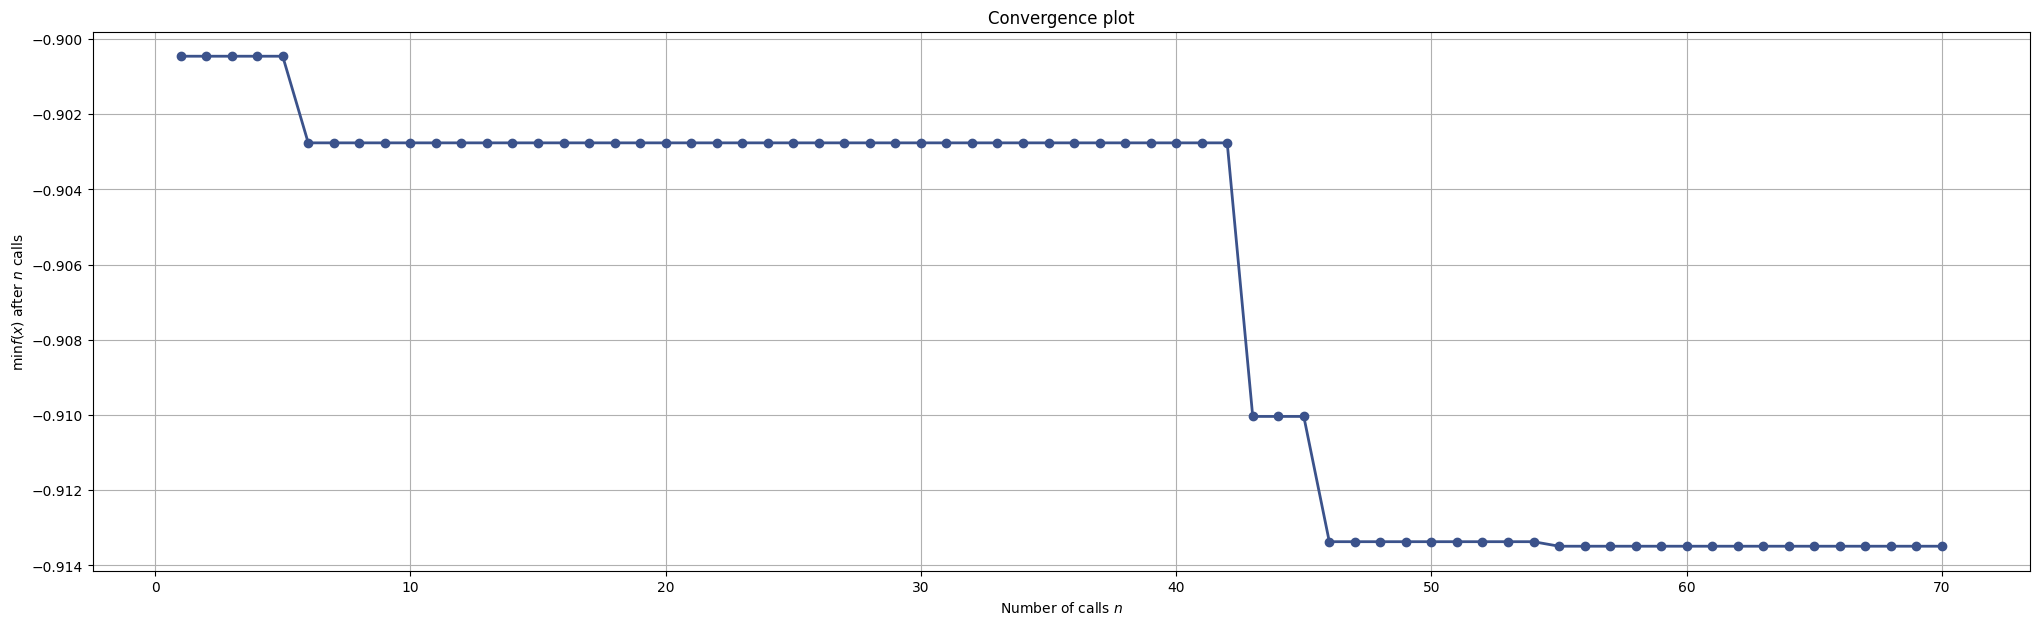

In [ ]:
plt.figure(figsize=(25,7))
plot_convergence(fm_)
plt.show()

Wow, after Bayesian optimization, model performance jumped from ROC-AUC = 0.85 to ROC-AUC=0.91. Thus, we can see the importance and performance gain from the optimization on top of the transformer.

Let's see the impact of each of the dimensions explored:

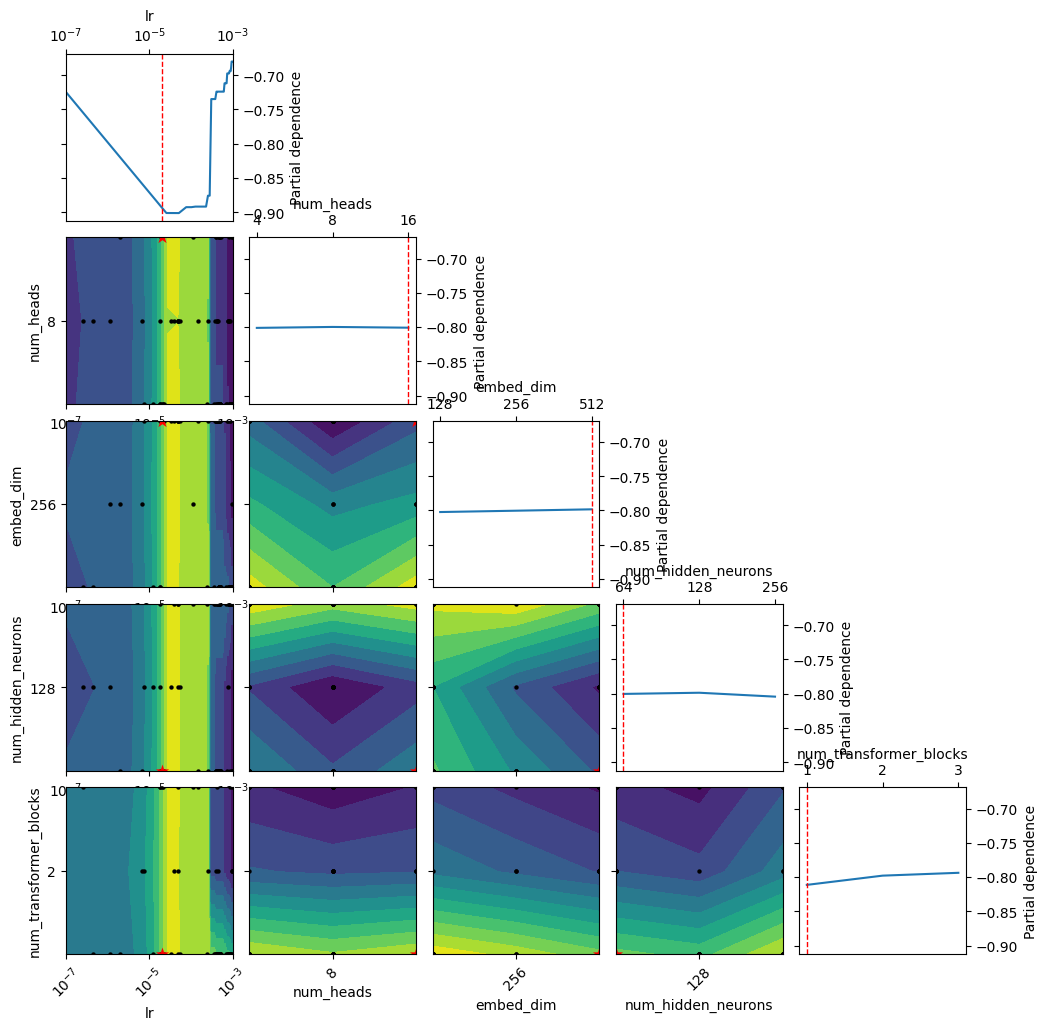

In [ ]:
plot_objective(result=fm_)
plt.show()

We can see that the choice of learning rate has a significant impact on transformer performance. The other optimized hyperparameters do not show a significant performance gain.

In the next and last notebook, we will train the transformer with optimized hyperparameters with all the training data (X_train,X_valid,X_opt) and evaluate the final performance.